# Classification

In [1]:
#@title necessary imports and classes
"""
File operations including downloading and extracting
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import shutil
import logging
import contextlib
import traceback
from urllib import request
from urllib.error import HTTPError
import gzip
from tqdm import tqdm
import numpy as np

logger = logging.getLogger(__name__)


class DownloadProgressBar(tqdm):
    """ Small helper class to make a download bar """

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


class FileOP:
    """
    Class for file operations including downloading, extracting and file size checking.

    Parameters:
    - data_output_dir (Optional[str]): The directory to store the downloaded files.

    Attributes:
    - data_output_dir (str): The directory to store the downloaded files.
    - url (None or str): The URL of the file to download.

    Methods:
    - unzip(in_file: str, out_file: str) -> int: Unzips a .gz file and returns the file size.
    - file_size_from_url(url: str) -> int: Gets the size of a file without downloading it.
    - download_from_url(url: str, download_dir: str, extract: bool = True, delete_after_extract: bool = False, ext_list: Optional[List[str]] = None) -> str: Downloads a file from a URL and
    * returns the file path.

    """
    def __init__(self, data_output_dir=None):
        self.data_output_dir = data_output_dir
        self.url = None

    def unzip(self, in_file, out_file):
        """
        Unzip .gz file and return file size
        :param in_file: complete file path of compressed .gz file
        :param out_file: complete file path of output file
        :return: os.path.getsize(out_file) in bytes
        """
        if not os.path.isfile(out_file):
            try:
                with gzip.open(in_file, 'rb') as f_in, open(out_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                logger.error(f'gzip failed on file: {in_file}: {e}')
                print(f'gzip failed on file: {in_file}: {e}')
                file_size = None
            else:
                file_size = os.path.getsize(out_file)
        else:
            print(f'Uncompressed output file exists: {out_file}. Skipping.')
            file_size = os.path.getsize(out_file)
        return file_size

    def file_size_from_url(self, url):
        """
        Method to acquire size of a file without download
        :param: url
        :returns: size in bytes (int)
        """
        url_size = np.nan
        try:
            with contextlib.closing(request.urlopen(url)) as ul:
                url_size = ul.length
        except HTTPError as http_err:
            logger.error(f'ERROR: {http_err}: URL: {url}')
        except Exception as e:
            logger.error(f'ERROR {e}: URL: {url}')
        return url_size

    def download_from_url(self, url, download_dir, extract=True, delete_after_extract=False, ext_list=None):
        """
        :param url: cloud storage location URL
        :param download_dir: path-like object representing file path.
        :param extract: extract file if compressed
        :param delete_after_extract: if file is an archive, delete file after extraction.
        :param ext_list: list of allowed extensions, for example '.json.gz' or '.zip'
        :return: file path of output file
        """
        output_file_name = os.path.basename(url)
        if ext_list is not None:
            ext_in_url = [xt for xt in ext_list if xt in url]
            if len(ext_in_url) > 0:
                xt = ext_in_url[0]
                output_file_name = f'{output_file_name.split(xt, maxsplit=1)[0]}{xt}'
        output_file = os.path.join(download_dir, output_file_name)
        if os.path.exists(download_dir):
            if not os.path.exists(output_file):
                try:
                    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=output_file_name) as t:
                        request.urlretrieve(url, filename=output_file, reporthook=t.update_to)
                except HTTPError as http_err:
                    print(http_err)
                    logger.error(f'Download failed for URL: {url}'
                                 f' {http_err}')
                except Exception as e:
                    traceback.print_exc()
                    logger.error(f'Download failed for URL: {url}'
                                 f' {e}')
                else:
                    logger.info(f'Download complete: {output_file}.')
            else:
                logger.info(f'File exists: {output_file}')
            # Unpacking
            output_file_path = output_file
            if os.path.exists(output_file) and extract:
                file_parts = os.path.splitext(output_file)
                xt = file_parts[-1]
                if xt in ['.gz']:
                    print(f'Extracting from {xt} archive.')
                    out_file = file_parts[0]
                    file_size = self.unzip(in_file=output_file, out_file=out_file)
                    if file_size is not None:
                        output_file_path = out_file
                        if delete_after_extract:
                            os.unlink(output_file)
                            logger.info(f'Deleted compressed file {output_file}')
                elif xt in ['.json', '.csv', '.pickle', '.parquet', '.ckpt', '.pth']:
                    print(f'Created {xt} file.')
                else:
                    print(f'File: {xt} loaded.')
                    logger.warning(f'File extension is unexpected {xt}.')
            elif os.path.exists(output_file) and not extract:
                output_file_path = output_file
        else:
            logger.error(f'Output directory {download_dir} does not exist.')
            output_file_path = None
        return output_file_path

"""
Tools for working with the Dentex Challenge data
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import numpy as np
import logging
import tarfile
import json


logger = logging.getLogger(__name__)


def val_test_split(data, label_col=None, n_test_per_class=30, n_val_per_class=30, random_state=123):
    """
    Splits the given data into training, validation, and test sets based on the specified parameters.
    Args:
        data: A pandas DataFrame containing the data to be split.
        label_col: The name of the column in the data DataFrame that contains the labels.
        n_test_per_class: The number of samples per class to be allocated to the test set. Default is 30.
        n_val_per_class: The number of samples per class to be allocated to the validation set. Default is 30.
        random_state: The seed value used by the random number generator. Default is 123.
    Returns:
        A new pandas DataFrame with an additional column, 'dataset', indicating the split for each sample.
        The 'dataset' column will have one of the following values: 'train', 'val', or 'test'.
    """
    image_numbers = {'test': n_test_per_class,
                     'val': n_val_per_class}
    dset_df = data.copy().sample(frac=1, random_state=random_state). \
        assign(dataset=None).reset_index(drop=True)
    for dataset in image_numbers.keys():
        if label_col is not None:
            labels = dset_df[label_col].unique()
            for label in labels:
                np.random.seed(random_state)
                idx_list = np.random.choice(dset_df. \
                                            loc[(dset_df[label_col] == label) & (dset_df['dataset'].isnull())]. \
                                            index, size=image_numbers.get(dataset), replace=False)
                dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset
        else:
            np.random.seed(random_state)
            idx_list = np.random.choice(dset_df.
                                        loc[dset_df['dataset'].isnull()].
                                        index, size=image_numbers.get(dataset), replace=False)
            dset_df.loc[dset_df.index.isin(idx_list), 'dataset'] = dataset

    # Use the remaining samples for training
    dset_df.loc[dset_df['dataset'].isnull(), 'dataset'] = 'train'
    return dset_df


class DentexData:
    def __init__(self, data_dir):
        self.annotations_file = None
        self.annotations = None
        self.data_dir = data_dir
        self.classification_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz'
        self.detection_url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz'
        if not os.path.exists(self.data_dir):
            logger.warning('Data directory does not exist')

    def create_category_dict(self, categories=None):
        """
        Create a dictionary of categories.
        :param categories: A list of category IDs. Default is None.
        :type categories: list, optional
        :return: A dictionary containing category names as keys and a sub-dictionary as values.
                 The sub-dictionary contains category IDs as keys and category names as values.
        :rtype: dict
        """
        if categories is None:
            categories = range(1, 4)
        category_dict = {}
        if self.annotations is not None:
            for category_id in categories:
                category_name = f'categories_{category_id}'
                cat_list = self.annotations.get(category_name)
                id_list = [c.get('id') for c in cat_list]
                nm_list = [c.get('name') for c in cat_list]
                category_dict.update({category_name: dict(zip(id_list, nm_list))})
        else:
            logger.warning('No annotations. Run "load_annotations" method first.')
        return category_dict

    def download_image_data(self, url):
        """
        Downloads image data from a specified URL
        Parameters:
        - url (str): The URL from which to download the image data.
        If not provided, the method will use the default classification URL.
        Returns:
        - data_tar_file (str): The path to the downloaded data TAR file.
        Raises:
        - ValueError: If an incomplete file exists at the specified URL.
        Example usage:
        download_image_data(url='https://www.example.com/data.tar')
        """
        data_tar_file = FileOP().download_from_url(url=url, download_dir=self.data_dir)
        if data_tar_file is not None and os.path.exists(data_tar_file):
            try:
                with tarfile.open(data_tar_file) as tar:
                    tar.extractall(path=self.data_dir)
            except Exception as e:
                logger.error(f'Could not extract: {e}')
        return data_tar_file

    def load_annotations(self, json_file):
        try:
            with open(json_file, 'r') as f:
                self.annotations = json.load(f)
                self.annotations_file = json_file
        except IOError as e:
            logger.error(f'Could not read {json_file}: {e}')
        return self.annotations

"""
Methods for image processing
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import copy
import numpy as np
import cv2
import logging
from skimage import io
from PIL import Image

logger = logging.getLogger(name=__name__)


def clip_range(r, max_val):
    return max(min(r, max_val), 0)


def transform_box(box_padded, pad_pixels, img):
    """
    Transform bounding box from padded to original image
    """
    img_h, img_w = img.shape[:2]
    x, y, w, h = box_padded - float(pad_pixels)
    output_box = tuple([clip_range(x, img_w),
                        clip_range(y, img_h),
                        clip_range(w, img_w),
                        clip_range(h, img_h)])
    return output_box


def crop_image(image, box):
    """
    Crops an object in an image by bounding box
    :Parameters:
        image: (np.ndarray) image data
        box: (tuple) (x_min, y_min, width, height)
    :returns:
        crop_img: (np.ndarray) cropped image
    """
    x, y, w, h = [int(np.round(c)) for c in box]
    return image[y:h, x:w, :]


def is_image(image_file_path):
    """
    Checks if the given file path corresponds to an image file.
    Parameters:
        image_file_path (str): The path to the file.
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    file_is_image = False
    if os.path.exists(image_file_path):
        try:
            Image.open(image_file_path)
        except Exception as ex:
            logger.warning(f'File: {image_file_path} is not an image.')
        else:
            file_is_image = True
    else:
        logger.warning(f'File: {image_file_path} does not exist.')
    return file_is_image


def validate_image_data(data_df, file_path_col):
    """ Load and validate images from data frame
    :parameters:
        data_df (pd.DataFrame): data frame with image file paths
        file_path_col (list): List of columns with file paths
    :returns
        output_df (pd.DataFrame): data frame with valid file paths
    """
    output_df = copy.deepcopy(data_df)
    file_path_col = [file_path_col] if isinstance(file_path_col, str) else file_path_col
    for col in file_path_col:
        n_start = len(output_df)
        output_df = output_df.loc[output_df[col].apply(is_image)]
        n_dropped = n_start - len(output_df)
        if n_dropped > 0:
            warning_msg = f'Dropped {n_dropped} rows from bad data in column: {col}.'
            logger.warning(warning_msg)
        else:
            logger.info('All files validated.')
    return output_df


class ImageData:
    """ Load and transform images """

    def __init__(self, resize=None):
        self.resize = resize
        self.image_net_mean = [0.485, 0.456, 0.406]
        self.image_net_std = [0.229, 0.224, 0.225]

    def load_image(self, image_path):
        """ Load image as np.ndarray
        Parameters:
            image_path: (str) complete path to image file
        Returns:
            output_array: (np.ndarray) (uint8)
        """
        output_array = None
        if os.path.exists(image_path):
            try:
                with open(image_path, mode='rb') as fl:
                    img = io.imread(fl)
            except Exception as ex:
                read_error_msg = f'Unable to read: {image_path}'
                print(read_error_msg)
                logger.error(read_error_msg)
            else:
                output_array = img.astype(np.uint8)
        else:
            error_msg = f'Image file: {image_path} does not exist.'
            print(error_msg)
            logger.error(error_msg)
        return output_array

    def image_size(self, image_path):
        """ Load image and return size in pixels (height, width) """
        output = None
        if is_image(image_path):
            output_array = self.load_image(image_path)
            if output_array is not None:
                output = tuple(output_array.shape)
        return output

    def np_square_pad(self, im_array, pad_pixels, pad_number=0):
        """ Pad 2D image
        Parameters:
            im_array: (np.ndarray) 2D numpy array
            pad_pixels: (int) pixels to add on each side
            pad_number: (int) gray value in [0, 256]
        """
        assert len(im_array.shape) == 2, f'Require 2D grayscale image.'

        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value

        output = np.pad(im_array, pad_pixels, pad_with, padder=pad_number)
        return output

    def np2color(self, im_array, color_scheme='RGB'):
        """ Convert np.ndarray into color image
        Parameters:
            im_array: (np.ndarray) 2D or 3D numpy array
            color_scheme: (str) 'RGB', 'BGR' or 'GRAY'
        """
        assert color_scheme in ['RGB', 'BGR', 'GRAY'], f'color_scheme must be RGB, BGR or GRAY'
        if len(im_array.shape) == 2:
            color_code_str = f'cv2.COLOR_GRAY2{color_scheme}'
            image = cv2.cvtColor(im_array, code=eval(color_code_str))
        elif len(im_array.shape) == 3:
            if color_scheme == 'RGB':
                image = im_array.copy()
            else:
                color_code_str = f'cv2.COLOR_RGB2{color_scheme}'
                image = cv2.cvtColor(im_array, code=eval(color_code_str))
        else:
            raise NotImplementedError('input array must be 2D or 3D.')
        return image

    def convert_transparent_png(self, img):
        """ Decomposing the alpha channel for 4 channel png file """
        # image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        output_image = img
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha_channel = img[:, :, 3]
            rgb_channels = img[:, :, :3]
            white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255
            alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255.0
            alpha_factor = np.concatenate((alpha_factor, alpha_factor, alpha_factor), axis=2)
            base = rgb_channels.astype(np.float32) * alpha_factor
            white = white_background_image.astype(np.float32) * (1 - alpha_factor)
            output_image = (base + white).astype(np.uint8)
        return output_image

    def resize_image_list(self, image_list, output_size):
        """ Match size for multiple inputs before augmentation
        Parameters:
            image_list, list of images
            output_size, int or tuple, size of output image
        """
        assert any([isinstance(output_size, int),
                    isinstance(output_size, tuple)]), 'output_size must be of type int or tuple.'

        if isinstance(output_size, int):
            dim = (output_size, output_size)
        else:
            dim = output_size

        output_image_list = [cv2.resize(im, dim, interpolation=cv2.INTER_AREA) for im in image_list]
        return output_image_list

    def hist_eq(self, img):
        """ Adaptive histogram equalization
        Parameters:
            img (np.ndarray) RGB image
        Returns:
            enhanced_img (np.ndarray) RGB image with enhanced contrast
        """
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)
        lim_g = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lim_g, cv2.COLOR_LAB2RGB)
        return enhanced_img


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import tarfile
import random
import time
import glob
import json
from pathlib import Path

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


In [3]:
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(model_dir).mkdir(parents=True, exist_ok=True)

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')

# Lets create a directory for the output
output_dir = os.path.join(data_dir, 'output')
Path(output_dir).mkdir(exist_ok=True, parents=True)

In [4]:
# Create an instance of the DentexData class
dtx = DentexData(data_dir=data_dir)
url = dtx.classification_url
sz = FileOP().file_size_from_url(url)
sz_GB = sz/1.0e9

# Download and extract the data
print(f'Downloading {sz_GB:.2f} GB from:\n{dtx.classification_url}')
data_tar_file = dtx.download_image_data(url=url)

# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 705
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Extracted {len(file_list)} images.')

https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration-disease.tar.gz


dentex-quadrant-enumeration-disease.tar.gz: 2.15GB [00:42, 50.3MB/s]                            


Extracting from .gz archive.
Extracted 705 images.


In [5]:
# Create a data frame with the image file paths
file_name_list = [os.path.basename(file) for file in file_list]
im_number_list = [int(os.path.splitext(file)[0].rsplit('_', maxsplit=1)[-1]) for file in file_name_list]
files = pd.DataFrame({'image_number': im_number_list,
                      'file_name': file_name_list,
                      'file_path': file_list}).\
                sort_values(by='image_number', ascending=True).reset_index(drop=True)

display(files.head())

,image_number,file_name,file_path
0,0,train_0.png,DATA_ROOT/dentex/dentex_classification/quadran...
1,1,train_1.png,DATA_ROOT/dentex/dentex_classification/quadran...
2,2,train_2.png,DATA_ROOT/dentex/dentex_classification/quadran...
3,3,train_3.png,DATA_ROOT/dentex/dentex_classification/quadran...
4,4,train_4.png,DATA_ROOT/dentex/dentex_classification/quadran...


In [6]:
# Load the annotation file
annotation_file = os.path.join(data_dir,
                               'quadrant-enumeration-disease',
                               'train_quadrant_enumeration_disease.json')
annotations = dtx.load_annotations(annotation_file)
print(f'Loaded annotations from file:\n{dtx.annotations_file}\n{annotations.keys()}')

Loaded annotations from file:
DATA_ROOT/dentex/dentex_classification/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
dict_keys(['images', 'annotations', 'categories_1', 'categories_2', 'categories_3'])


In [7]:
# Add image ids to the files data frame
js_im_df = pd.DataFrame(annotations.get('images')).\
                merge(files, on='file_name', how='inner').\
                sort_values(by='id', ascending=True).\
                reset_index(drop=True).\
                rename(columns={'id': 'image_id'}).\
                drop(['height', 'width'], axis=1)
display(js_im_df.head())
print(js_im_df.shape)

,image_id,file_name,image_number,file_path
0,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...
1,2,train_283.png,283,DATA_ROOT/dentex/dentex_classification/quadran...
2,3,train_435.png,435,DATA_ROOT/dentex/dentex_classification/quadran...
3,4,train_95.png,95,DATA_ROOT/dentex/dentex_classification/quadran...
4,5,train_475.png,475,DATA_ROOT/dentex/dentex_classification/quadran...


(705, 4)


In [8]:
# Create a dictionary of categories with IDs and names
# The categories are described in a dictionary at the top of the JSON file
display(dtx.annotations.keys())
print()
# We can create one dictionary with the labels for each annotation
categories = dtx.create_category_dict()
display(categories)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2', 'categories_3'])

{'categories_1': {0: '1', 1: '2', 2: '3', 3: '4'},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'},
 'categories_3': {0: 'Impacted',
  1: 'Caries',
  2: 'Periapical Lesion',
  3: 'Deep Caries'}}

In [9]:
# Loop over the annotations
an_df_list = []
for idx, an_dict in enumerate(annotations.get('annotations')):
    if (idx + 1) % 500 == 0:
        print(f'Annotation {idx + 1} / {len(annotations.get("annotations"))}')

    image_id = an_dict.get('image_id')
    id_df = js_im_df.loc[js_im_df['image_id'] == image_id]

    # Find the quadrant, tooth position and disease categories for this annotation
    quadrant_id = an_dict.get('category_id_1')
    quadrant = categories.get('categories_1').get(quadrant_id)

    position_id = an_dict.get('category_id_2')
    position = categories.get('categories_2').get(position_id)

    disease_id = an_dict.get('category_id_3')
    disease = categories.get('categories_3').get(disease_id)

    id_df = id_df.assign(quadrant=quadrant,
                         position=position,
                         label=disease,
                         cl = disease_id,
                         area=[an_dict.get('area')],
                         bbox=[an_dict.get('bbox')],
                         box_name=(f'{os.path.splitext(id_df["file_name"].values[0])[0]}_'
                                   f'{idx}_{quadrant}_{position}'))
    an_df_list.append(id_df)
an_df = pd.concat(an_df_list, axis=0, ignore_index=True)

# Add the number of annotations to each image
n_annotations = an_df[['file_name', 'label']].\
                groupby('file_name').count().\
                reset_index(drop=False).\
                rename(columns={'label': 'annotations'})

an_df = an_df.merge(n_annotations, on='file_name', how='inner').\
                sort_values(by='image_id', ascending=True).\
                reset_index(drop=True)

print()
display(an_df.head())

Annotation 500 / 3529
Annotation 1000 / 3529
Annotation 1500 / 3529
Annotation 2000 / 3529
Annotation 2500 / 3529
Annotation 3000 / 3529
Annotation 3500 / 3529



,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations
0,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Impacted,0,39683,"[542.0, 698.0, 220.0, 271.0]",train_673_0_4_8,13
1,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,3,8,Impacted,0,33301,"[1952.0, 693.0, 177.0, 270.0]",train_673_1_3_8,13
2,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,4,7,Caries,1,45758,"[675.0, 708.0, 243.0, 300.0]",train_673_2_4_7,13
3,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,3,3,Caries,1,30985,"[1463.0, 725.0, 98.0, 425.0]",train_673_3_3_3,13
4,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,3,4,Caries,1,28044,"[1536.0, 753.0, 103.0, 381.0]",train_673_4_3_4,13


In [10]:
# Show an xray image with bounging boxes
np.random.seed(123)
file_name_list = np.random.choice(an_df['file_name'].unique(), size=20, replace=False)
#file_name_list = ['train_265.png', 'train_269.png', 'train_270.png']
for file_name in file_name_list:
    an_file_df = an_df.loc[(an_df['file_name'] == file_name)]
    #                        (an_df['position'] == '6') &
    #                        (an_df['quadrant'] == '4')]

    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    #im = ImageData().hist_eq(im)

    # Create a list of colors for the rectangles
    color = cm.rainbow(np.linspace(0, 1, len(an_file_df)))
    color_list = [color[c] for c in range(len(color))]
    text_offset_xy = (-10, -10)

    # Create the figure and show the panoramic x-ray image
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(im)

    # Loop over the bounding boxes
    for i, idx in enumerate(an_file_df.index):

        box_df = an_file_df.loc[an_file_df.index==idx]

        box = box_df['bbox'].values[0]
        bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
        label = box_df['label'].values[0]


        rect = patches.Rectangle(xy=(box[0], box[1]), width=box[2], height=box[3],
                                         linewidth=1.5, edgecolor=color_list[i],
                                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)

        ax.text(box[0]+text_offset_xy[0],
                box[1]+text_offset_xy[1]+i,
                label,
                color='r',
                fontsize='small',
                fontweight='medium')

        ax.set(xticks=[], yticks=[])


    image_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
    plt.savefig(os.path.join(output_dir, image_name), bbox_inches='tight')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Save the data frame with the file paths and annotations
df_file_name = 'dentex_disease_dataset.parquet'
df_file = os.path.join(data_dir, df_file_name)
an_df.to_parquet(df_file)
print(f'Annotation data frame saved: {df_file}')

Annotation data frame saved: DATA_ROOT/dentex/dentex_classification/dentex_disease_dataset.parquet


In [12]:
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

df_file_name = 'dentex_disease_dataset.parquet'
df_file = os.path.join(data_dir, df_file_name)

# Load the annotation data frame
an_df = pd.read_parquet(df_file)
print()
display(an_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations
0,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Impacted,0,39683,"[542.0, 698.0, 220.0, 271.0]",train_673_0_4_8,13
1,1,train_673.png,673,DATA_ROOT/dentex/dentex_classification/quadran...,3,8,Impacted,0,33301,"[1952.0, 693.0, 177.0, 270.0]",train_673_1_3_8,13


In [13]:
# File path for the cropped images
cropped_image_dir = os.path.join(image_dir, 'crop')
Path(cropped_image_dir).mkdir(exist_ok=True)
file_name_list = sorted(an_df['file_name'].unique())

# Start a list of new data frames
data_df_list = []

# Loop over the panoramic x-rays
for f, file_name in enumerate(file_name_list):
    box_name_list = an_df.loc[an_df['file_name'] == file_name, 'box_name'].values
    if (f + 1) % 50 == 0:
        print(f'Processing image {f+1} / {len(file_name_list)}')
    # Loop over the bounding boxes for this file
    for b, box_name in enumerate(box_name_list):
        box_file = os.path.join(cropped_image_dir, f'{box_name}.png')

        # Get the row in the data frame
        box_df = an_df.loc[(an_df['file_name'] == file_name) & (an_df['box_name'] == box_name)].\
                        assign(box_file=box_file)
        box = box_df['bbox'].values[0]
        bbox = box[0], box[1], box[0] + box[2], box[1] + box[3]
        label = box_df['label'].values[0]
        file = os.path.join(image_dir, file_name)

        if not os.path.exists(box_file):

            # Load the image and then crop it
            im = ImageData().load_image(file)
            im_crop = crop_image(im, bbox)

            # Some contrast enhancement
            im_crop_enhanced = ImageData().hist_eq(im_crop)

            # Save the image
            cv2.imwrite(box_file, cv2.cvtColor(im_crop_enhanced, cv2.COLOR_RGB2BGR))

        # Add the image size to the data frame
        box_file_size = ImageData().image_size(box_file)
        box_df = box_df.assign(im_width=box_file_size[1],
                               im_height=box_file_size[0])

        # Add the data frame for this image to the list
        data_df_list.append(box_df)

# Concatenate the data frames
data_df = pd.concat(data_df_list, axis=0, ignore_index=True)

Processing image 50 / 678
Processing image 100 / 678
Processing image 150 / 678
Processing image 200 / 678
Processing image 250 / 678
Processing image 300 / 678
Processing image 350 / 678
Processing image 400 / 678
Processing image 450 / 678
Processing image 500 / 678
Processing image 550 / 678
Processing image 600 / 678
Processing image 650 / 678


In [14]:
# Save the data frame
display(data_df.head())
df_box_file = df_file.replace('dataset', 'cropped_dataset')
print(df_box_file)
data_df.to_parquet(df_box_file)

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height
0,57,train_0.png,0,DATA_ROOT/dentex/dentex_classification/quadran...,2,6,Caries,1,33015,"[1791.0, 445.72727272727263, 147.4545454545452...",train_0_334_2_6,2,DATA_ROOT/dentex/dentex_classification/quadran...,147,323
1,57,train_0.png,0,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Caries,1,35006,"[682.090909090909, 687.5454545454545, 200.0, 3...",train_0_335_4_8,2,DATA_ROOT/dentex/dentex_classification/quadran...,200,300
2,442,train_1.png,1,DATA_ROOT/dentex/dentex_classification/quadran...,3,8,Impacted,0,32013,"[1978.125, 723.9583333333334, 144.791666666666...",train_1_2311_3_8,2,DATA_ROOT/dentex/dentex_classification/quadran...,145,301
3,442,train_1.png,1,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Impacted,0,36765,"[729.6296296296296, 713.5802469135803, 166.666...",train_1_2310_4_8,2,DATA_ROOT/dentex/dentex_classification/quadran...,166,295
4,198,train_10.png,10,DATA_ROOT/dentex/dentex_classification/quadran...,4,7,Caries,1,30598,"[702.0, 772.0, 194.0, 246.0]",train_10_1055_4_7,5,DATA_ROOT/dentex/dentex_classification/quadran...,194,246


DATA_ROOT/dentex/dentex_classification/dentex_disease_cropped_dataset.parquet


In [15]:
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = data_root

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

df_box_file_name = 'dentex_disease_cropped_dataset.parquet'
df_box_file = os.path.join(data_dir, df_box_file_name)

In [16]:
# Load the data frame with image paths and bounding boxes
data_df = pd.read_parquet(df_box_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height
0,57,train_0.png,0,DATA_ROOT/dentex/dentex_classification/quadran...,2,6,Caries,1,33015,"[1791.0, 445.72727272727263, 147.4545454545452...",train_0_334_2_6,2,DATA_ROOT/dentex/dentex_classification/quadran...,147,323
1,57,train_0.png,0,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Caries,1,35006,"[682.090909090909, 687.5454545454545, 200.0, 3...",train_0_335_4_8,2,DATA_ROOT/dentex/dentex_classification/quadran...,200,300


In [17]:
# Function to create the data splits
label_col = 'label'
dset_df = val_test_split(data=data_df,
                         label_col=label_col,
                         n_test_per_class=30,
                         n_val_per_class=30)

In [18]:
# Make sure that we have three non-overlapping data sets
train_set = set(dset_df.loc[dset_df['dataset']=='train', 'box_name'].values)
print(f'We have {len(train_set)} images in the train set.')

val_set = set(dset_df.loc[dset_df['dataset']=='val', 'box_name'].values)
print(f'We have {len(val_set)} images in the validation set.')

test_set = set(dset_df.loc[dset_df['dataset']=='test', 'box_name'].values)
print(f'We have {len(test_set)} images in the test set.')
print()

# Make sure that these data sets are distinct
print(train_set.intersection(val_set))
print(train_set.intersection(test_set))
print(val_set.intersection(test_set))

We have 3289 images in the train set.
We have 120 images in the validation set.
We have 120 images in the test set.

set()
set()
set()


In [19]:
# Save the data split
datasplit_file_name = 'dentex_disease_datasplit.parquet'
datasplit_file = os.path.join(data_dir, datasplit_file_name)
dset_df.to_parquet(datasplit_file)
print(datasplit_file)
display(dset_df.head())

DATA_ROOT/dentex/dentex_classification/dentex_disease_datasplit.parquet


,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,DATA_ROOT/dentex/dentex_classification/quadran...,3,5,Caries,1,27169,"[1620.388349514563, 693.2038834951456, 150.485...",train_418_3037_3_5,9,DATA_ROOT/dentex/dentex_classification/quadran...,151,358,train
2,202,train_391.png,391,DATA_ROOT/dentex/dentex_classification/quadran...,1,7,Caries,1,38560,"[808.0, 433.0, 166.0, 317.0]",train_391_1064_1_7,17,DATA_ROOT/dentex/dentex_classification/quadran...,166,317,train
3,535,train_659.png,659,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Caries,1,42396,"[753.0, 611.0, 269.0, 277.0]",train_659_2767_4_8,1,DATA_ROOT/dentex/dentex_classification/quadran...,269,277,train
4,632,train_587.png,587,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Deep Caries,3,33478,"[595.5172413793103, 398.3103448275863, 160.344...",train_587_3148_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,160,276,train


In [20]:
# GPU checks
import torch
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [21]:
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')


data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)
# Load the data frame with image paths
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,DATA_ROOT/dentex/dentex_classification/quadran...,3,5,Caries,1,27169,"[1620.388349514563, 693.2038834951456, 150.485...",train_418_3037_3_5,9,DATA_ROOT/dentex/dentex_classification/quadran...,151,358,train


In [22]:
# We have the images sizes in the data frame
# Finding the largest image and its dimensions is easy
im_max_width = data_df['im_width'].max()
im_max_height = data_df['im_height'].max()
print(f'Maximum image width across the data set:  {im_max_width}')
print(f'Maximum image height across the data set: {im_max_height}')
# Set the maximum image size for all images
im_max_size = int(np.max((im_max_width, im_max_height)))
print(f'Maximum image size: {im_max_size}')

Maximum image width across the data set:  363
Maximum image height across the data set: 539
Maximum image size: 539


In [23]:
#@title Load library
"""
Create PyTorch data set from data frames
Andreas Werdich
Center for Computational Biomedicine
"""

import numpy as np
import logging
import torch
from torch.utils.data import Dataset
import albumentations as alb
import cv2
from albumentations.augmentations.geometric.resize import LongestMaxSize
from albumentations.augmentations.geometric.transforms import PadIfNeeded

# Imports from this module
# from dentexmodel.imageproc import ImageData, validate_image_data

logger = logging.getLogger(name=__name__)


def load_and_process_image(image_file_path, max_image_size=550):
    """
    Image preprocessing
    """
    # For the albumentations transformation, max_image_size needs to be of type 'int'
    if not isinstance(max_image_size, int):
        max_image_size = int(max_image_size)
    transform = alb.Compose([LongestMaxSize(max_size=max_image_size),
                             PadIfNeeded(min_height=max_image_size,
                                         min_width=max_image_size,
                                         border_mode=cv2.BORDER_CONSTANT,
                                         value=0)])
    im_raw = ImageData().load_image(image_file_path)
    im_output = transform(image=im_raw)['image']
    return im_output


class DatasetFromDF(Dataset):
    """
    Creates a PyTorch dataset from a data frame
    """

    def __init__(self,
                 data,
                 file_col,
                 label_col,
                 max_image_size,
                 transform=None,
                 validate=False):
        """
        Attributes:
        data (pd.DataFrame):    file paths and labels
        file_col (str):         column name for file paths
        label_col (str):        column name for corresponding labels
        max_image_size (int):   Resize and square pad all images to this size
        transform     (alb):     transformation object
        verify        (bool):    load and verify all images on instantiation
        """
        self.df = data
        self.file_col = file_col
        self.label_col = label_col
        self.max_image_size = max_image_size
        self.transform = transform
        self.validate = validate
        if self.validate:
            validate_image_data(data_df=self.df, file_path_col=self.file_col)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        idx = idx % self.__len__()
        df_idx = self.df.iloc[idx]
        file, label = df_idx[self.file_col], df_idx[self.label_col]
        assert isinstance(label, np.int64), f'Label must be type np.int64.'
        # Image preprocessing, e.g., color conversion
        img = load_and_process_image(image_file_path=file, max_image_size=self.max_image_size)
        if self.transform:
            img = self.transform(image=img)['image']
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        # For grayscale images, we need to add a color dimension.
        # img_tensor = torch.unsqueeze(img_tensor, dim=0)
        # img_tensor = img_tensor.permute(2, 0, 1)
        label_tensor = torch.from_numpy(np.array(label))
        output = tuple([img_tensor, label_tensor])
        return output

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


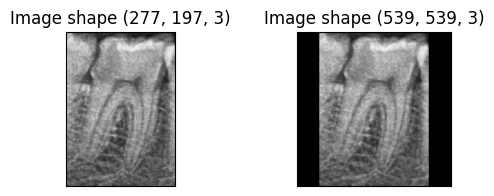

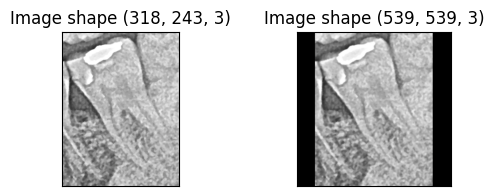

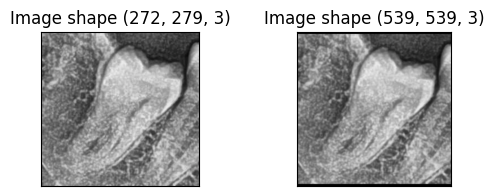

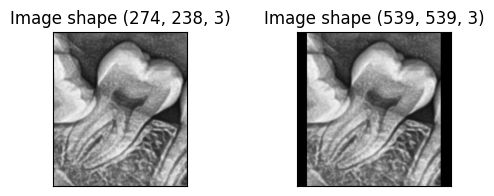

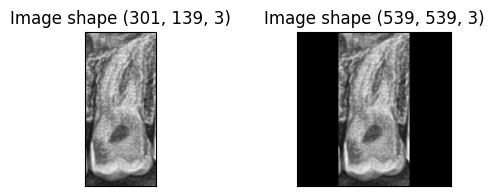

In [24]:
# Take a look at a few images
np.random.seed(234)
image_list = np.random.choice(data_df['box_name'].unique(), size=5, replace=False)
for i, image in enumerate(image_list):
    # Load the image
    image_file = os.path.join(cropped_image_dir, f'{image}.png')
    im = ImageData().load_image(image_file)
    # Pre-process the image
    im_processed = load_and_process_image(image_file_path=image_file,
                                          max_image_size=im_max_size)
    # Show the two images side-by-side
    im_list = [im, im_processed]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
    for a, axa in enumerate(ax):
        axa.imshow(im_list[a])
        axa.set_title(f'Image shape {im_list[a].shape}')
        axa.set(xticks=[], yticks=[])
    plt.show()

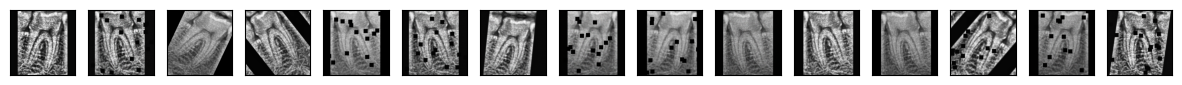

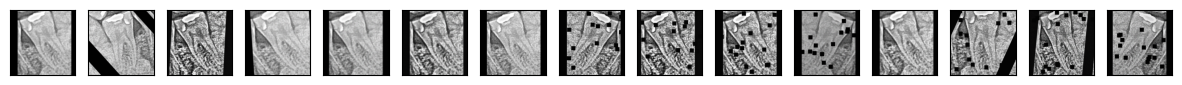

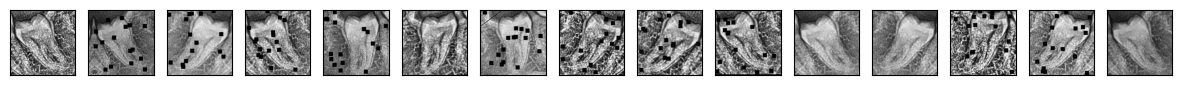

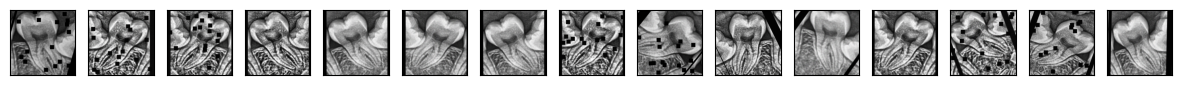

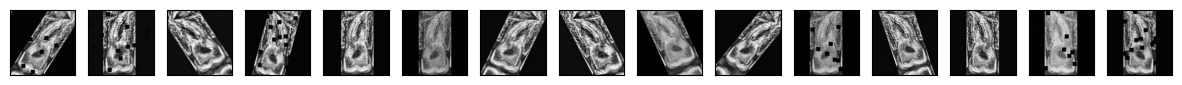

In [25]:
# This is the input size for the model
im_size = 512
# Here is a list of example augmentations
# A complete list of pixel-level transformations is here
# https://github.com/albumentations-team/albumentations#pixel-level-transforms
train_aug = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE()])
# Set the number of random transformations
n_transforms = 15
figsize = (15, 15)
for image in image_list:
    image_file = os.path.join(cropped_image_dir, f'{image}.png')
    im = load_and_process_image(image_file_path=image_file, max_image_size=im_max_size)
    fig, ax = plt.subplots(nrows=1, ncols=n_transforms, figsize=figsize)
    for n in range(n_transforms):
        im_aug = train_aug(image=im)['image']
        ax[n].imshow(im_aug)
        ax[n].set(xticks=[], yticks=[])
    plt.show()

In [26]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch methods
import torch
from torch.utils.data import DataLoader

In [27]:
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [28]:
data_df = pd.read_parquet(data_file)
label_list = sorted(list(data_df['label'].unique()))
cl_list = [data_df.loc[data_df['label']==label, 'cl'].values[0] for label in label_list]
cl_dict = dict(zip(cl_list, label_list))
display(cl_dict)
print()
display(data_df.head())

{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,DATA_ROOT/dentex/dentex_classification/quadran...,3,5,Caries,1,27169,"[1620.388349514563, 693.2038834951456, 150.485...",train_418_3037_3_5,9,DATA_ROOT/dentex/dentex_classification/quadran...,151,358,train
2,202,train_391.png,391,DATA_ROOT/dentex/dentex_classification/quadran...,1,7,Caries,1,38560,"[808.0, 433.0, 166.0, 317.0]",train_391_1064_1_7,17,DATA_ROOT/dentex/dentex_classification/quadran...,166,317,train
3,535,train_659.png,659,DATA_ROOT/dentex/dentex_classification/quadran...,4,8,Caries,1,42396,"[753.0, 611.0, 269.0, 277.0]",train_659_2767_4_8,1,DATA_ROOT/dentex/dentex_classification/quadran...,269,277,train
4,632,train_587.png,587,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Deep Caries,3,33478,"[595.5172413793103, 398.3103448275863, 160.344...",train_587_3148_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,160,276,train


In [29]:
# Maximum image size
max_im_width = data_df['im_width'].max()
max_im_height = data_df['im_height'].max()

print(f'Maximum image height across the data set: {max_im_height}')
print(f'Maximum image width across the data set:  {max_im_width}')

# The maximum dimension is the max_im_height:
max_image_size = np.max([max_im_height, max_im_width])

Maximum image height across the data set: 539
Maximum image width across the data set:  363


In [30]:
# Image augmentations is part of the PyTorch dataset

# The output of this transformation must match the required input size for the model
im_size = 512

# Definition of the image augmentations for the training set
train_transform = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE(),
    alb.Normalize(mean=0, std=1)])

# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
val_transform = alb.Compose([
    alb.Resize(im_size, im_size),
    alb.Normalize(mean=0, std=1)])

In [31]:
train_df = data_df.loc[data_df['dataset'] == 'train']
display(train_df['label'].value_counts())

# Create the data sets from the data frame
train_dataset = DatasetFromDF(data=train_df,
                              file_col='box_file',
                              label_col='cl',
                              max_image_size=max_image_size,
                              transform=train_transform,
                              validate=True)

,count
label,
Caries,2129
Impacted,544
Deep Caries,518
Periapical Lesion,98


In [32]:
def image_stats(ig, decimals=3):

    """ Returns pandas series with image stats """

    output_dict = {'im_width': ig.shape[1],
                   'im_height': ig.shape[0],
                   'im_min': np.round(np.min(ig), decimals=decimals),
                   'im_max': np.round(np.max(ig), decimals=decimals),
                   'im_mean': np.round(np.mean(ig), decimals=decimals),
                   'im_std': np.round(np.std(ig), decimals=decimals)}

    return pd.DataFrame(output_dict, index=[0]).iloc[0]

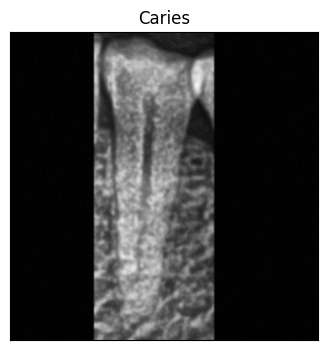

,0
im_width,512.000
im_height,512.000
im_min,0.000
im_max,1.000
im_mean,0.177
im_std,0.237


In [33]:
# Retrieve one (image, label) sample from the data set
image_index = 234
image_sample, label_sample = train_dataset[image_index]
# We need to move the color channel back to the end of the array
image = np.transpose(image_sample.numpy(), (1, 2, 0))
label = cl_dict.get(int(label_sample.numpy()))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set(xticks=[], yticks=[], title=str(label))
plt.show()
print()
display(image_stats(image))

In [34]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=train_dataset, batch_size=16)

# The dataloader can be converted into an iterator which returns images and labels
image_batch, label_batch = next(iter(dataloader))

print(f'Size of the image batch: {image_batch.numpy().shape}')
print(f'Labels:                  {label_batch.numpy()}')

Size of the image batch: (16, 3, 512, 512)
Labels:                  [0 1 1 1 3 3 1 1 1 1 1 3 3 1 0 0]


In [35]:
%%capture
!python -m pip install pytorch-lightning
!pip install lightning


In [36]:
#@title toothmodel basic
"""
Minimal model code for training and inference
Andreas Werdich
Center for Computational Biomedicine
Harvard Medical School
"""

import logging
from typing import Any

# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights

# Lightning module
from lightning.pytorch import LightningModule
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, OptimizerLRScheduler, STEP_OUTPUT

logger = logging.getLogger(name=__name__)
torch.set_float32_matmul_precision(precision='high')


class ResNet50Model:
    """

    Class: ResNet50Model

    A class representing a ResNet-50 model with customizable number of outputs.

    Methods: - __init__(self, n_outputs=4): Initializes a new instance of the ResNet50Model class with the specified
    number of outputs. - create_model(self): Creates and returns a ResNet-50 model with the specified number of outputs.

    """
    def __init__(self, n_outputs=4):
        self.n_outputs = n_outputs

    def create_model(self):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(in_features=model.fc.in_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.n_outputs)
        )
        return model


class ToothModel(LightningModule):
    """
    ToothModel

    This class represents a PyTorch Lightning module for training and predicting tooth models.

    Attributes:
        train_dataset (Dataset): The training dataset.
        batch_size (int): The batch size for data loading.
        num_workers (int, optional): The number of workers for data loading. Defaults to 1.
        lr (float, optional): The learning rate for the optimizer. Defaults to 1.0e-3.
        model (nn.Module, optional): The pre-trained model. Defaults to None.
        decimals (int): The number of decimal places to round floating point numbers to.

    Methods:
        train_dataloader() -> TRAIN_DATALOADERS:
            Returns the training dataloader for the module.

        forward(x, *args: Any, **kwargs: Any) -> Any:
            Performs a forward pass through the model.

        training_step(batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
            Performs a training step on a batch of data.

        predict_step(batch, batch_idx, *args: Any, **kwargs: Any) -> Any:
            Performs a prediction step on a batch of data.

        configure_optimizers() -> OptimizerLRScheduler:
            Configures the optimizer and learning rate scheduler for training.

    """
    def __init__(self,
                 train_dataset,
                 batch_size,
                 num_workers=1,
                 lr=1.0e-3,
                 model=None):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.train_dataset = train_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.decimals = 5
        # Model architecture
        if model is None:
            self.model = ResNet50Model().create_model()
        else:
            self.model = model
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        dl = DataLoader(self.train_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=True,
                        pin_memory=True)
        return dl

    def forward(self, x, *args: Any, **kwargs: Any) -> Any:
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, label = batch
        pred = self.forward(image)
        loss = self.criterion(pred, label)
        return loss

    def predict_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> Any:
        image, label = batch
        output = self.forward(image)
        return output

    def configure_optimizers(self) -> OptimizerLRScheduler:
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return opt

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


torch.Size([4, 3, 512, 512])
torch.Size([4])


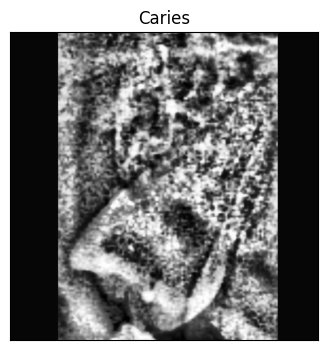

In [37]:

model = ToothModel(train_dataset=train_dataset,
                   batch_size=4,
                   num_workers=0)

dl = model.train_dataloader()
image_batch, label_batch = next(iter(dl))

print(image_batch.shape)
print(label_batch.shape)

# Plot one image from the batch with label
image_idx = 0
image = np.transpose(image_batch.numpy()[image_idx], axes=(1, 2, 0))
label = cl_dict.get(label_batch.numpy()[image_idx])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image, cmap='gray')
ax.set_title(label)
ax.set(xticks=[], yticks=[])
plt.show()

In [38]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateFinder, LearningRateMonitor
import torchmetrics

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


In [39]:
#@title Import libraries
"""
Advanced model class for training and inference
With automated learning rate scheduling and TensorBoard logging
Andreas Werdich
Center for Computational Biomedicine
Harvard Medical School
"""

import logging
from typing import Any
# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, ResNet50_Weights
# Lightning module
from lightning.pytorch import LightningModule
from lightning.pytorch.utilities.types import OptimizerLRScheduler, STEP_OUTPUT
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from lightning.pytorch.callbacks import LearningRateFinder
# Torchmetrics
import torchmetrics.classification as tmc

logger = logging.getLogger(name=__name__)
torch.set_float32_matmul_precision(precision='high')


def performance_metrics(metric_dict, logits, target, metric_prefix='train'):
    """
    Calculate performance metrics for given logits and targets.

    Args:
        metric_dict (dict): Dictionary containing the metric name as key and the metric function as value.
        logits (torch.Tensor): The predicted logits from the model.
        target (torch.Tensor): The ground truth targets.
        metric_prefix (str, optional): Prefix to be added to the metric name. Defaults to 'train'.

    Returns:
        dict: Dictionary containing the performance metrics with metric name prefixed by metric_prefix.
    """
    preds = nn.Softmax(dim=1)(logits)
    performance_dict = {}
    for metric_name, metric in metric_dict.items():
        performance_dict.update({f'{metric_prefix}_{metric_name}': metric(preds=preds, target=target)})
    return performance_dict


def average_performance_metrics(step_metrics_list, decimals=3):
    """
    This method calculates the average performance metrics.
    Parameters:
    - step_metrics_list (list): A list of dictionaries where each dictionary represents the metrics for a step.
    - decimals (int, optional): The number of decimal places to round the average metrics to. Defaults to 3.
    Returns:
    - average_metrics (dict): A dictionary containing the average value for each performance metric.
    """
    average_metrics = {}
    for metric in step_metrics_list[0].keys():
        metric_value = torch.stack([x.get(metric) for x in step_metrics_list])
        # Remove any zero values before averaging
        metric_value = metric_value[metric_value.nonzero().squeeze()]
        metric_value = metric_value.mean().detach().cpu().numpy().round(decimals)
        average_metrics[metric] = metric_value
    return average_metrics


class FineTuneLearningRateFinder(LearningRateFinder):
    """
    FineTuneLearningRateFinder is a class that extends the LearningRateFinder class.
    It is used to find the optimal learning rate for fine-tuning a model during training.
    Attributes:
        milestones (List[int]): A list of epoch numbers at which the learning rate should be evaluated.
    """
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)


class ResNet50Model:
    """
    This class represents a ResNet-50 model for image classification.
    Attributes:
    - n_outputs (int): The number of output classes for the model.
    Methods:
    - __init__(self, n_outputs=4): Initializes a new instance of the ResNet50Model class.
    - create_model(self): Creates the ResNet-50 model with a custom fully connected layer.
    """

    def __init__(self, n_outputs=4):
        self.n_outputs = n_outputs

    def create_model(self):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(in_features=model.fc.in_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.n_outputs)
        )
        return model


class ToothModel(LightningModule):
    """
    This class represents a model for tooth classification using PyTorch Lightning.

    Parameters:
        - train_dataset: The dataset used for training.
        - val_dataset: The dataset used for validation.
        - test_dataset: The dataset used for testing.
        - batch_size: The batch size used for training, validation, and testing.
        - num_classes: The number of classes in the classification problem.
        - num_workers: The number of subprocesses used for data loading. Default is 1.
        - lr: The learning rate for the optimizer. Default is 1.0e-3.
        - model: Optional pretrained model. If not provided, a ResNet50 model will be used.

    Example usage:

    train_dataset = ToothDataset(train_data)
    val_dataset = ToothDataset(val_data)
    test_dataset = ToothDataset(test_data)

    tooth_model = ToothModel(train_dataset, val_dataset, test_dataset, batch_size=64, num_classes=10)

    trainer = pl.Trainer()
    trainer.fit(tooth_model)
    trainer.test(tooth_model)

    Note: replace `TRAIN_DATALOADERS`, `EVAL_DATALOADERS`, `STEP_OUTPUT`, `OptimizerLRScheduler` with the appropriate
    types.
    """

    def __init__(self,
                 train_dataset,
                 val_dataset,
                 test_dataset,
                 batch_size,
                 num_classes,
                 num_workers=1,
                 lr=1.0e-3,
                 model=None):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers
        self.lr = lr
        self.decimals = 5
        # Model architecture
        if model is None:
            self.model = ResNet50Model().create_model()
        else:
            self.model = model
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        # Performance metrics
        self.metrics = nn.ModuleDict({
            'accuracy': tmc.MulticlassAccuracy(num_classes=num_classes, average='micro'),
            'precision': tmc.MulticlassPrecision(num_classes=num_classes, average='macro'),
            'recall': tmc.MulticlassRecall(num_classes=num_classes, average='macro'),
            'f1': tmc.MulticlassF1Score(num_classes=num_classes, average='macro'),
            'auroc': tmc.MulticlassAUROC(num_classes=num_classes, average='macro')
        })
        self.train_step_metrics_list = []
        self.val_step_metrics_list = []
        self.test_step_metrics_list = []

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        dl = DataLoader(self.train_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=True,
                        pin_memory=True)
        return dl

    def val_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.val_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def test_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.test_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def forward(self, x, *args: Any, **kwargs: Any) -> Any:
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        train_step_metrics = {'train_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='train')
        train_step_metrics.update(performance_dict)
        self.train_step_metrics_list.append(train_step_metrics)
        return loss

    def validation_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        val_step_metrics = {'val_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='val')
        val_step_metrics.update(performance_dict)
        self.val_step_metrics_list.append(val_step_metrics)
        return loss

    def predict_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> Any:
        image, label = batch
        output = self.forward(image)
        return output

    def configure_optimizers(self) -> OptimizerLRScheduler:
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        lr_scheduler_config = {'scheduler': scheduler,
                               'interval': 'epoch',
                               'frequency': 1,
                               'monitor': 'val_loss',
                               'strict': False,
                               'name': 'lr'}
        output = {'optimizer': opt, 'lr_scheduler': lr_scheduler_config}
        return output

    def on_train_epoch_end(self) -> None:
        if len(self.train_step_metrics_list) > 0:
            epoch_train_metrics = average_performance_metrics(step_metrics_list=self.train_step_metrics_list,
                                                              decimals=self.decimals)
            self.log_dict(epoch_train_metrics, prog_bar=False)
        self.train_step_metrics_list.clear()

    def on_validation_epoch_end(self) -> None:
        if len(self.val_step_metrics_list) > 0:
            epoch_val_metrics = average_performance_metrics(step_metrics_list=self.val_step_metrics_list,
                                                            decimals=self.decimals)
            # Manually log learning rate
            epoch_val_metrics['val_lr'] = self.lr
            self.log_dict(epoch_val_metrics, prog_bar=True)
        self.val_step_metrics_list.clear()

In [40]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [41]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [42]:
data_df = pd.read_parquet(data_file)
# Convert class names to labels
cl_names = sorted(list(data_df['label'].unique()))
# Get the class labels
cl_numbers = [data_df.loc[data_df['label'] == label, 'cl'].values[0] for label in cl_names]
label_dict = dict(zip(cl_names, cl_numbers))
cl_dict = dict(zip(cl_numbers, cl_names))
# Show the class labels
display(pd.DataFrame(label_dict, index=[0]).iloc[0])

,0
Caries,1
Deep Caries,3
Impacted,0
Periapical Lesion,2


In [43]:
# Select the samples for training, validation and testing from our data frame
train_df = data_df.loc[data_df['dataset']=='train']
val_df = data_df.loc[data_df['dataset']=='val']
test_df = data_df.loc[data_df['dataset']=='test']

train_samples = sorted(list(train_df['box_name'].unique()))
print(f'Found {len(train_samples)} samples in the training set.')
val_samples = sorted(list(val_df['box_name'].unique()))
print(f'Found {len(val_samples)} samples in the validation set.')
test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')

Found 3289 samples in the training set.
Found 120 samples in the validation set.
Found 120 samples in the test set.


In [44]:
# Augmentations
# Image augmentations is part of the PyTorch dataset

# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224

# Definition of the image augmentations for the training set
train_transform = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE(),
    alb.Normalize(mean=ImageData().image_net_mean,
                  std=ImageData().image_net_std)])

# For validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
val_transform = alb.Compose([
    alb.Resize(im_size, im_size),
    alb.Normalize(mean=ImageData().image_net_mean,
                  std=ImageData().image_net_std)])

In [45]:
# Create the data sets from the data frame
train_dataset = DatasetFromDF(data=train_df,
                              file_col='box_file',
                              label_col='cl',
                              max_image_size=max_image_size,
                              transform=train_transform,
                              validate=True)

val_dataset = DatasetFromDF(data=val_df,
                            file_col='box_file',
                            label_col='cl',
                            max_image_size=max_image_size,
                            transform=val_transform,
                            validate=True)

test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col='cl',
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)

In [46]:
# Model parameters and name
seed = 234
model_name = 'FancyLR'
model_version = 1
# Train for 40 epochs to get good results
max_epochs = 5
num_classes = 4
num_workers = 2
batch_size = 16
initial_lr = 1.0e-3
check_val_every_n_epoch = 1
checkpoint_every_n_epoch = 2
save_top_k = 3

In [47]:
# Create the model
model = ToothModel(train_dataset=train_dataset,
                   val_dataset=val_dataset,
                   test_dataset=test_dataset,
                   batch_size=batch_size,
                   num_classes=num_classes,
                   num_workers=num_workers,
                   lr=initial_lr)

# Setup logger
logger = TensorBoardLogger(save_dir=model_dir,
                           name=model_name,
                           version=model_version)

# Checkpoint callback
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

Path(checkpoint_dir).mkdir(exist_ok=True, parents=True)
chk_callback = ModelCheckpoint(dirpath=checkpoint_dir,
                               filename='dentexmodel-{epoch}',
                               monitor='val_loss',
                               mode='min',
                               save_last=True,
                               every_n_epochs=checkpoint_every_n_epoch,
                               save_on_train_epoch_end=True,
                               save_top_k=save_top_k)

In [48]:
lr_finder = FineTuneLearningRateFinder(milestones=(5, 10),
                                       min_lr=1.0e-8,
                                       max_lr=0.01,
                                       num_training_steps=100,
                                       mode='exponential',
                                       early_stop_threshold=None,
                                       update_attr=True)

lr_starter = LearningRateFinder(min_lr=1.0e-8,
                                max_lr=0.01,
                                num_training_steps=300,
                                mode='exponential',
                                early_stop_threshold=None,
                                update_attr=True)

lr_monitor = LearningRateMonitor(logging_interval='epoch',
                                 log_momentum=True)

In [49]:
print(f'Training the "{model_name}" model for {max_epochs} epochs.')
print()

tr = Trainer(max_epochs=max_epochs,
             default_root_dir=model_dir,
             callbacks=[chk_callback, lr_finder, lr_monitor],
             logger=logger,
             check_val_every_n_epoch=check_val_every_n_epoch)
tr.fit(model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training the "FancyLR" model for 5 epochs.



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 24.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
2 | metrics   | ModuleDict       | 0      | train
-------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.237    Total estimated model params size (MB)
161       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 24.6 M | train
1 | criterion | CrossEntropyLoss | 0      | train
2 | metrics   | ModuleDict       | 0      | train
-----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00015848931924611126
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00015848931924611126
INFO: Restoring states from the checkpoint path at DATA_ROOT/model/.lr_find_eabcbb7f-fd0d-44b7-aa79-f400a94023f6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at DATA_ROOT/model/.lr_find_eabcbb7f-fd0d-44b7-aa79-f400a94023f6.ckpt
INFO: Restored all states from the checkpoint at DATA_ROOT/model/.lr_find_eabcbb7f-fd0d-44b7-aa79-f400a94023f6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the chec

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [50]:
#@title Import libraries

# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
import torchmetrics

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

"""
File operations including downloading and extracting
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import shutil
import logging
import contextlib
import traceback
from urllib import request
from urllib.error import HTTPError
import gzip
from tqdm import tqdm
import numpy as np

logger = logging.getLogger(__name__)


class DownloadProgressBar(tqdm):
    """ Small helper class to make a download bar """

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


class FileOP:
    """
    Class for file operations including downloading, extracting and file size checking.

    Parameters:
    - data_output_dir (Optional[str]): The directory to store the downloaded files.

    Attributes:
    - data_output_dir (str): The directory to store the downloaded files.
    - url (None or str): The URL of the file to download.

    Methods:
    - unzip(in_file: str, out_file: str) -> int: Unzips a .gz file and returns the file size.
    - file_size_from_url(url: str) -> int: Gets the size of a file without downloading it.
    - download_from_url(url: str, download_dir: str, extract: bool = True, delete_after_extract: bool = False, ext_list: Optional[List[str]] = None) -> str: Downloads a file from a URL and
    * returns the file path.

    """
    def __init__(self, data_output_dir=None):
        self.data_output_dir = data_output_dir
        self.url = None

    def unzip(self, in_file, out_file):
        """
        Unzip .gz file and return file size
        :param in_file: complete file path of compressed .gz file
        :param out_file: complete file path of output file
        :return: os.path.getsize(out_file) in bytes
        """
        if not os.path.isfile(out_file):
            try:
                with gzip.open(in_file, 'rb') as f_in, open(out_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            except Exception as e:
                logger.error(f'gzip failed on file: {in_file}: {e}')
                print(f'gzip failed on file: {in_file}: {e}')
                file_size = None
            else:
                file_size = os.path.getsize(out_file)
        else:
            print(f'Uncompressed output file exists: {out_file}. Skipping.')
            file_size = os.path.getsize(out_file)
        return file_size

    def file_size_from_url(self, url):
        """
        Method to acquire size of a file without download
        :param: url
        :returns: size in bytes (int)
        """
        url_size = np.nan
        try:
            with contextlib.closing(request.urlopen(url)) as ul:
                url_size = ul.length
        except HTTPError as http_err:
            logger.error(f'ERROR: {http_err}: URL: {url}')
        except Exception as e:
            logger.error(f'ERROR {e}: URL: {url}')
        return url_size

    def download_from_url(self, url, download_dir, extract=True, delete_after_extract=False, ext_list=None):
        """
        :param url: cloud storage location URL
        :param download_dir: path-like object representing file path.
        :param extract: extract file if compressed
        :param delete_after_extract: if file is an archive, delete file after extraction.
        :param ext_list: list of allowed extensions, for example '.json.gz' or '.zip'
        :return: file path of output file
        """
        output_file_name = os.path.basename(url)
        if ext_list is not None:
            ext_in_url = [xt for xt in ext_list if xt in url]
            if len(ext_in_url) > 0:
                xt = ext_in_url[0]
                output_file_name = f'{output_file_name.split(xt, maxsplit=1)[0]}{xt}'
        output_file = os.path.join(download_dir, output_file_name)
        if os.path.exists(download_dir):
            if not os.path.exists(output_file):
                try:
                    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=output_file_name) as t:
                        request.urlretrieve(url, filename=output_file, reporthook=t.update_to)
                except HTTPError as http_err:
                    print(http_err)
                    logger.error(f'Download failed for URL: {url}'
                                 f' {http_err}')
                except Exception as e:
                    traceback.print_exc()
                    logger.error(f'Download failed for URL: {url}'
                                 f' {e}')
                else:
                    logger.info(f'Download complete: {output_file}.')
            else:
                logger.info(f'File exists: {output_file}')
            # Unpacking
            output_file_path = output_file
            if os.path.exists(output_file) and extract:
                file_parts = os.path.splitext(output_file)
                xt = file_parts[-1]
                if xt in ['.gz']:
                    print(f'Extracting from {xt} archive.')
                    out_file = file_parts[0]
                    file_size = self.unzip(in_file=output_file, out_file=out_file)
                    if file_size is not None:
                        output_file_path = out_file
                        if delete_after_extract:
                            os.unlink(output_file)
                            logger.info(f'Deleted compressed file {output_file}')
                elif xt in ['.json', '.csv', '.pickle', '.parquet', '.ckpt', '.pth']:
                    print(f'Created {xt} file.')
                else:
                    print(f'File: {xt} loaded.')
                    logger.warning(f'File extension is unexpected {xt}.')
            elif os.path.exists(output_file) and not extract:
                output_file_path = output_file
        else:
            logger.error(f'Output directory {download_dir} does not exist.')
            output_file_path = None
        return output_file_path

"""
Methods for image processing
Andreas Werdich
Center for Computational Biomedicine
"""

import os
import copy
import numpy as np
import cv2
import logging
from skimage import io
from PIL import Image

logger = logging.getLogger(name=__name__)


def clip_range(r, max_val):
    return max(min(r, max_val), 0)


def transform_box(box_padded, pad_pixels, img):
    """
    Transform bounding box from padded to original image
    """
    img_h, img_w = img.shape[:2]
    x, y, w, h = box_padded - float(pad_pixels)
    output_box = tuple([clip_range(x, img_w),
                        clip_range(y, img_h),
                        clip_range(w, img_w),
                        clip_range(h, img_h)])
    return output_box


def crop_image(image, box):
    """
    Crops an object in an image by bounding box
    :Parameters:
        image: (np.ndarray) image data
        box: (tuple) (x_min, y_min, width, height)
    :returns:
        crop_img: (np.ndarray) cropped image
    """
    x, y, w, h = [int(np.round(c)) for c in box]
    return image[y:h, x:w, :]


def is_image(image_file_path):
    """
    Checks if the given file path corresponds to an image file.
    Parameters:
        image_file_path (str): The path to the file.
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    file_is_image = False
    if os.path.exists(image_file_path):
        try:
            Image.open(image_file_path)
        except Exception as ex:
            logger.warning(f'File: {image_file_path} is not an image.')
        else:
            file_is_image = True
    else:
        logger.warning(f'File: {image_file_path} does not exist.')
    return file_is_image


def validate_image_data(data_df, file_path_col):
    """ Load and validate images from data frame
    :parameters:
        data_df (pd.DataFrame): data frame with image file paths
        file_path_col (list): List of columns with file paths
    :returns
        output_df (pd.DataFrame): data frame with valid file paths
    """
    output_df = copy.deepcopy(data_df)
    file_path_col = [file_path_col] if isinstance(file_path_col, str) else file_path_col
    for col in file_path_col:
        n_start = len(output_df)
        output_df = output_df.loc[output_df[col].apply(is_image)]
        n_dropped = n_start - len(output_df)
        if n_dropped > 0:
            warning_msg = f'Dropped {n_dropped} rows from bad data in column: {col}.'
            logger.warning(warning_msg)
        else:
            logger.info('All files validated.')
    return output_df


class ImageData:
    """ Load and transform images """

    def __init__(self, resize=None):
        self.resize = resize
        self.image_net_mean = [0.485, 0.456, 0.406]
        self.image_net_std = [0.229, 0.224, 0.225]

    def load_image(self, image_path):
        """ Load image as np.ndarray
        Parameters:
            image_path: (str) complete path to image file
        Returns:
            output_array: (np.ndarray) (uint8)
        """
        output_array = None
        if os.path.exists(image_path):
            try:
                with open(image_path, mode='rb') as fl:
                    img = io.imread(fl)
            except Exception as ex:
                read_error_msg = f'Unable to read: {image_path}'
                print(read_error_msg)
                logger.error(read_error_msg)
            else:
                output_array = img.astype(np.uint8)
        else:
            error_msg = f'Image file: {image_path} does not exist.'
            print(error_msg)
            logger.error(error_msg)
        return output_array

    def image_size(self, image_path):
        """ Load image and return size in pixels (height, width) """
        output = None
        if is_image(image_path):
            output_array = self.load_image(image_path)
            if output_array is not None:
                output = tuple(output_array.shape)
        return output

    def np_square_pad(self, im_array, pad_pixels, pad_number=0):
        """ Pad 2D image
        Parameters:
            im_array: (np.ndarray) 2D numpy array
            pad_pixels: (int) pixels to add on each side
            pad_number: (int) gray value in [0, 256]
        """
        assert len(im_array.shape) == 2, f'Require 2D grayscale image.'

        def pad_with(vector, pad_width, iaxis, kwargs):
            pad_value = kwargs.get('padder', 10)
            vector[:pad_width[0]] = pad_value
            vector[-pad_width[1]:] = pad_value

        output = np.pad(im_array, pad_pixels, pad_with, padder=pad_number)
        return output

    def np2color(self, im_array, color_scheme='RGB'):
        """ Convert np.ndarray into color image
        Parameters:
            im_array: (np.ndarray) 2D or 3D numpy array
            color_scheme: (str) 'RGB', 'BGR' or 'GRAY'
        """
        assert color_scheme in ['RGB', 'BGR', 'GRAY'], f'color_scheme must be RGB, BGR or GRAY'
        if len(im_array.shape) == 2:
            color_code_str = f'cv2.COLOR_GRAY2{color_scheme}'
            image = cv2.cvtColor(im_array, code=eval(color_code_str))
        elif len(im_array.shape) == 3:
            if color_scheme == 'RGB':
                image = im_array.copy()
            else:
                color_code_str = f'cv2.COLOR_RGB2{color_scheme}'
                image = cv2.cvtColor(im_array, code=eval(color_code_str))
        else:
            raise NotImplementedError('input array must be 2D or 3D.')
        return image

    def convert_transparent_png(self, img):
        """ Decomposing the alpha channel for 4 channel png file """
        # image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        output_image = img
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha_channel = img[:, :, 3]
            rgb_channels = img[:, :, :3]
            white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255
            alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255.0
            alpha_factor = np.concatenate((alpha_factor, alpha_factor, alpha_factor), axis=2)
            base = rgb_channels.astype(np.float32) * alpha_factor
            white = white_background_image.astype(np.float32) * (1 - alpha_factor)
            output_image = (base + white).astype(np.uint8)
        return output_image

    def resize_image_list(self, image_list, output_size):
        """ Match size for multiple inputs before augmentation
        Parameters:
            image_list, list of images
            output_size, int or tuple, size of output image
        """
        assert any([isinstance(output_size, int),
                    isinstance(output_size, tuple)]), 'output_size must be of type int or tuple.'

        if isinstance(output_size, int):
            dim = (output_size, output_size)
        else:
            dim = output_size

        output_image_list = [cv2.resize(im, dim, interpolation=cv2.INTER_AREA) for im in image_list]
        return output_image_list

    def hist_eq(self, img):
        """ Adaptive histogram equalization
        Parameters:
            img (np.ndarray) RGB image
        Returns:
            enhanced_img (np.ndarray) RGB image with enhanced contrast
        """
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)
        lim_g = cv2.merge((cl, a, b))
        enhanced_img = cv2.cvtColor(lim_g, cv2.COLOR_LAB2RGB)
        return enhanced_img
"""
Create PyTorch data set from data frames
Andreas Werdich
Center for Computational Biomedicine
"""

import numpy as np
import logging
import torch
from torch.utils.data import Dataset
import albumentations as alb
import cv2
from albumentations.augmentations.geometric.resize import LongestMaxSize
from albumentations.augmentations.geometric.transforms import PadIfNeeded

# Imports from this module

logger = logging.getLogger(name=__name__)


def load_and_process_image(image_file_path, max_image_size=550):
    """
    Image preprocessing
    """
    # For the albumentations transformation, max_image_size needs to be of type 'int'
    if not isinstance(max_image_size, int):
        max_image_size = int(max_image_size)
    transform = alb.Compose([LongestMaxSize(max_size=max_image_size),
                             PadIfNeeded(min_height=max_image_size,
                                         min_width=max_image_size,
                                         border_mode=cv2.BORDER_CONSTANT,
                                         value=0)])
    im_raw = ImageData().load_image(image_file_path)
    im_output = transform(image=im_raw)['image']
    return im_output


class DatasetFromDF(Dataset):
    """
    Creates a PyTorch dataset from a data frame
    """

    def __init__(self,
                 data,
                 file_col,
                 label_col,
                 max_image_size,
                 transform=None,
                 validate=False):
        """
        Attributes:
        data (pd.DataFrame):    file paths and labels
        file_col (str):         column name for file paths
        label_col (str):        column name for corresponding labels
        max_image_size (int):   Resize and square pad all images to this size
        transform     (alb):     transformation object
        verify        (bool):    load and verify all images on instantiation
        """
        self.df = data
        self.file_col = file_col
        self.label_col = label_col
        self.max_image_size = max_image_size
        self.transform = transform
        self.validate = validate
        if self.validate:
            validate_image_data(data_df=self.df, file_path_col=self.file_col)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        idx = idx % self.__len__()
        df_idx = self.df.iloc[idx]
        file, label = df_idx[self.file_col], df_idx[self.label_col]
        assert isinstance(label, np.int64), f'Label must be type np.int64.'
        # Image preprocessing, e.g., color conversion
        img = load_and_process_image(image_file_path=file, max_image_size=self.max_image_size)
        if self.transform:
            img = self.transform(image=img)['image']
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        # For grayscale images, we need to add a color dimension.
        # img_tensor = torch.unsqueeze(img_tensor, dim=0)
        # img_tensor = img_tensor.permute(2, 0, 1)
        label_tensor = torch.from_numpy(np.array(label))
        output = tuple([img_tensor, label_tensor])
        return output


In [51]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = "DATA_ROOT"

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [52]:
data_df = pd.read_parquet(data_file)
# Convert class names to labels
cl_names = sorted(list(data_df['label'].unique()))
# Get the class labels
cl_numbers = [data_df.loc[data_df['label'] == label, 'cl'].values[0] for label in cl_names]
label_dict = dict(zip(cl_names, cl_numbers))
cl_dict = dict(zip(cl_numbers, cl_names))
# Show the class labels
display(pd.DataFrame(label_dict, index=[0]).iloc[0])

,0
Caries,1
Deep Caries,3
Impacted,0
Periapical Lesion,2


In [53]:
# Select the samples for training, validation and testing from our data frame
train_df = data_df.loc[data_df['dataset']=='train']
val_df = data_df.loc[data_df['dataset']=='val']
test_df = data_df.loc[data_df['dataset']=='test']

train_samples = sorted(list(train_df['box_name'].unique()))
print(f'Found {len(train_samples)} samples in the training set.')
val_samples = sorted(list(val_df['box_name'].unique()))
print(f'Found {len(val_samples)} samples in the validation set.')
test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()

Found 3289 samples in the training set.
Found 120 samples in the validation set.
Found 120 samples in the test set.



In [54]:
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224

# For validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
val_transform = alb.Compose([
    alb.Resize(im_size, im_size),
    alb.Normalize(mean=ImageData().image_net_mean,
                  std=ImageData().image_net_std)])

In [55]:
# Create the test data set from the data frame
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col='cl',
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)

In [56]:
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel_fancy_40.ckpt'
# link = '/content/DATA_ROOT/model/FancyLR/version_1/checkpoints/dentexmodel-epoch=3.ckpt'

# Let's see if we have a saved checkpoint
# The previous training notebook should have the defined model name
model_name = 'FancyLR'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

last_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'last.ckpt'))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "last.ckpt" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "last.ckpt" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "last.ckpt" in DATA_ROOT/model/FancyLR/version_1/checkpoints.


In [57]:
batch_size = 16
num_classes = 4
model = ToothModel.load_from_checkpoint(checkpoint_file,
                                        test_dataset=test_dataset,
                                        map_location=device,
                                        batch_size=batch_size,
                                        num_classes=num_classes,
                                        num_workers=1)

In [58]:
# We try the metrics with the trained model
# Load a test batch
dl = model.test_dataloader()
test_image_batch, test_label_batch = next(iter(dl))
display(test_image_batch.shape)
display(test_label_batch.shape)

# Forward - pass on the test batch
pred = model(test_image_batch.to(device))

torch.Size([16, 3, 224, 224])

torch.Size([16])

In [59]:
# True and predicted class labels
true_cl = test_label_batch.numpy()
pred_cl = torch.argmax(pred, dim=1).detach().cpu().numpy()
# From seeing this, the accuracy should be as shown
print(f'True class labels:      {true_cl}')
print(f'Predicted class labels: {pred_cl}')

# Accuracy
from sklearn.metrics import accuracy_score
acc = sum(pred_cl == true_cl)/batch_size
sk_acc = accuracy_score(y_true=true_cl, y_pred=pred_cl)
print(f'The accuracy should be: {acc:.3f}')
print(f'Scikit-Learn:           {sk_acc}')

# Precision for binary classification
# Precision is a metric that quantifies the number of correct predictions
# TruePositives / (TruePositives + FalsePositives)
prec_list = []
for cl in range(num_classes):
    true_bin_cl = [1 if label==cl else 0 for label in true_cl]
    pred_bin_cl = [1 if label==cl else 0 for label in pred_cl]
    true_positives_list = [1 if true_bin_cl[i]==pred_bin_cl[i]==1 else 0 for i in range(batch_size)]
    false_positives_list = [1 if (true_bin_cl[i]==0 and pred_bin_cl[i]==1) else 0 for i in range(batch_size)]
    true_positives = sum(true_positives_list)
    false_positives = sum(false_positives_list)

    # If there are no positive predictions in sample, we cannot calculate precision
    if true_positives==false_positives==0:
        prec_cl = 0
    else:
        prec_cl = true_positives / (true_positives + false_positives)
    print()
    print(f'Precision for class label {cl}: {prec_cl}')
    if prec_cl==0:
        print(f'WARNING: No positive samples in batch for label {cl}.')
    print(true_bin_cl)
    print(pred_bin_cl)
    prec_list.append(prec_cl)

# Calculate average precision across classes
print(f'Average precision: {sum(prec_list)/num_classes: .3f}')

# Precision from Scikit-Learn library
from sklearn.metrics import precision_score
sk_prec = precision_score(y_true=true_cl, y_pred=pred_cl, average='macro')
print(f'Scikit-Learn:      {sk_prec: .3f}')

True class labels:      [3 0 3 2 0 0 2 1 3 2 2 2 0 3 0 2]
Predicted class labels: [1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1]
The accuracy should be: 0.312
Scikit-Learn:           0.3125

Precision for class label 0: 1.0
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

Precision for class label 1: 0.08333333333333333
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

Precision for class label 2: 0
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision for class label 3: 0
[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Average precision:  0.271
Scikit-Learn:       0.271


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
# Show the calculations from Scikit-Learn
print(f'Accuracy:  {sk_acc}')
print(f'Precision:{sk_prec: .3f}')
# Recall
from sklearn.metrics import recall_score
sk_rec = recall_score(y_true=true_cl, y_pred=pred_cl, average='macro')
print(f'Recall:   {sk_rec: .3f}')

# F1 score
from sklearn.metrics import f1_score
sk_f1 = f1_score(y_true=true_cl, y_pred=pred_cl, average='macro')
print(f'F1:       {sk_f1: .3f}')

# AUC score
from sklearn.metrics import roc_auc_score
# For this, we need probability estimates for each class
sm = nn.Softmax(dim=1)
pred_cl_score = sm(pred).detach().cpu().numpy()
sk_auc = roc_auc_score(y_true=true_cl, y_score=pred_cl_score, average='macro', multi_class='ovr')
print(f'AUC:      {sk_auc: .3f}')

Accuracy:  0.3125
Precision: 0.271
Recall:    0.450
F1:        0.261
AUC:       0.872


In [61]:
true_cl = test_label_batch.to(device)
display(true_cl)
# Probability estimates for each class
sm = nn.Softmax(dim=1)
pred_cl_score = sm(pred)
pred_cl = torch.argmax(pred_cl_score, dim=1)
display(pred_cl)
print()

# Accuracy
from torchmetrics.classification import MulticlassAccuracy
acc = MulticlassAccuracy(num_classes=4, average='micro').to(device)
tm_acc = acc(preds=pred_cl_score, target=true_cl)
print(f'Accuracy:  {tm_acc}')

# Precision
from torchmetrics.classification import MulticlassPrecision
prec = MulticlassPrecision(num_classes=4, average='macro').to(device)
tm_prec = prec(preds=pred_cl_score, target=true_cl)
print(f'Precision:{tm_prec: .3f}')

# Recall
from torchmetrics.classification import MulticlassRecall
rec = MulticlassRecall(num_classes=4, average='macro').to(device)
tm_rec = rec(preds=pred_cl_score, target=true_cl)
print(f'Recall:   {tm_rec: .3f}')

# F1
from torchmetrics.classification import MulticlassF1Score
f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)
tm_f1 = f1(preds=pred_cl_score, target=true_cl)
print(f'F1:       {tm_f1: .3f}')

# AUC
from torchmetrics.classification import MulticlassAUROC
auc = MulticlassAUROC(num_classes=4, average='macro').to(device)
tm_auc = auc(preds=pred_cl_score, target=true_cl)
print(f'AUC:      {tm_auc: .3f}')

tensor([3, 0, 3, 2, 0, 0, 2, 1, 3, 2, 2, 2, 0, 3, 0, 2], device='cuda:0')

tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


Accuracy:  0.3125
Precision: 0.271
Recall:    0.450
F1:        0.261
AUC:       0.872


In [62]:
test_dict = nn.ModuleDict()

metric_dict = nn.ModuleDict({'acc': MulticlassAccuracy(num_classes=4, average='micro').to(device),
                             'prec': MulticlassPrecision(num_classes=4, average='macro').to(device)})

metric_prefix = 'train'
preds = sm(pred)
target = true_cl

performance_dict_1 = {}
for metric_name, metric in metric_dict.items():
    performance_dict_1.update({f'{metric_prefix}_{metric_name}': metric(preds=preds, target=target)})

performance_dict_2 = {}
for metric_name, metric in metric_dict.items():
    performance_dict_2.update({f'{metric_prefix}_{metric_name}': metric(preds=preds, target=target)+0.1})

performance_list = [performance_dict_1, performance_dict_2]
display(performance_list)

[{'train_acc': tensor(0.3125, device='cuda:0'),
  'train_prec': tensor(0.2708, device='cuda:0')},
 {'train_acc': tensor(0.4125, device='cuda:0'),
  'train_prec': tensor(0.3708, device='cuda:0')}]

In [63]:
# Now, we have to average the tensors in the dictionaries
key_list = list(performance_list[0].keys())
print(key_list)
key = key_list[0]
print(key)

epoch_performance_dict = {}
for metric_name in key_list:
    m = torch.stack([x.get(metric_name) for x in performance_list])
    n = m.mean().detach().cpu().numpy().round(2)
    epoch_performance_dict.update({metric_name: n})

print(epoch_performance_dict)

['train_acc', 'train_prec']
train_acc
{'train_acc': 0.36, 'train_prec': 0.32}


In [64]:
#@title Import libraries
"""
Advanced model class for training and inference
With automated learning rate scheduling and TensorBoard logging
Andreas Werdich
Center for Computational Biomedicine
Harvard Medical School
"""

import logging
from typing import Any
# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, ResNet50_Weights
# Lightning module
from lightning.pytorch import LightningModule
from lightning.pytorch.utilities.types import OptimizerLRScheduler, STEP_OUTPUT
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from lightning.pytorch.callbacks import LearningRateFinder
# Torchmetrics
import torchmetrics.classification as tmc

logger = logging.getLogger(name=__name__)
torch.set_float32_matmul_precision(precision='high')


def performance_metrics(metric_dict, logits, target, metric_prefix='train'):
    """
    Calculate performance metrics for given logits and targets.

    Args:
        metric_dict (dict): Dictionary containing the metric name as key and the metric function as value.
        logits (torch.Tensor): The predicted logits from the model.
        target (torch.Tensor): The ground truth targets.
        metric_prefix (str, optional): Prefix to be added to the metric name. Defaults to 'train'.

    Returns:
        dict: Dictionary containing the performance metrics with metric name prefixed by metric_prefix.
    """
    preds = nn.Softmax(dim=1)(logits)
    performance_dict = {}
    for metric_name, metric in metric_dict.items():
        performance_dict.update({f'{metric_prefix}_{metric_name}': metric(preds=preds, target=target)})
    return performance_dict


def average_performance_metrics(step_metrics_list, decimals=3):
    """
    This method calculates the average performance metrics.
    Parameters:
    - step_metrics_list (list): A list of dictionaries where each dictionary represents the metrics for a step.
    - decimals (int, optional): The number of decimal places to round the average metrics to. Defaults to 3.
    Returns:
    - average_metrics (dict): A dictionary containing the average value for each performance metric.
    """
    average_metrics = {}
    for metric in step_metrics_list[0].keys():
        metric_value = torch.stack([x.get(metric) for x in step_metrics_list])
        # Remove any zero values before averaging
        metric_value = metric_value[metric_value.nonzero().squeeze()]
        metric_value = metric_value.mean().detach().cpu().numpy().round(decimals)
        average_metrics[metric] = metric_value
    return average_metrics


class FineTuneLearningRateFinder(LearningRateFinder):
    """
    FineTuneLearningRateFinder is a class that extends the LearningRateFinder class.
    It is used to find the optimal learning rate for fine-tuning a model during training.
    Attributes:
        milestones (List[int]): A list of epoch numbers at which the learning rate should be evaluated.
    """
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)


class ResNet50Model:
    """
    This class represents a ResNet-50 model for image classification.
    Attributes:
    - n_outputs (int): The number of output classes for the model.
    Methods:
    - __init__(self, n_outputs=4): Initializes a new instance of the ResNet50Model class.
    - create_model(self): Creates the ResNet-50 model with a custom fully connected layer.
    """

    def __init__(self, n_outputs=4):
        self.n_outputs = n_outputs

    def create_model(self):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(in_features=model.fc.in_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.n_outputs)
        )
        return model


class ToothModel(LightningModule):
    """
    This class represents a model for tooth classification using PyTorch Lightning.

    Parameters:
        - train_dataset: The dataset used for training.
        - val_dataset: The dataset used for validation.
        - test_dataset: The dataset used for testing.
        - batch_size: The batch size used for training, validation, and testing.
        - num_classes: The number of classes in the classification problem.
        - num_workers: The number of subprocesses used for data loading. Default is 1.
        - lr: The learning rate for the optimizer. Default is 1.0e-3.
        - model: Optional pretrained model. If not provided, a ResNet50 model will be used.

    Example usage:

    train_dataset = ToothDataset(train_data)
    val_dataset = ToothDataset(val_data)
    test_dataset = ToothDataset(test_data)

    tooth_model = ToothModel(train_dataset, val_dataset, test_dataset, batch_size=64, num_classes=10)

    trainer = pl.Trainer()
    trainer.fit(tooth_model)
    trainer.test(tooth_model)

    Note: replace `TRAIN_DATALOADERS`, `EVAL_DATALOADERS`, `STEP_OUTPUT`, `OptimizerLRScheduler` with the appropriate
    types.
    """

    def __init__(self,
                 train_dataset,
                 val_dataset,
                 test_dataset,
                 batch_size,
                 num_classes,
                 num_workers=1,
                 lr=1.0e-3,
                 model=None):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers
        self.lr = lr
        self.decimals = 5
        # Model architecture
        if model is None:
            self.model = ResNet50Model().create_model()
        else:
            self.model = model
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        # Performance metrics
        self.metrics = nn.ModuleDict({
            'accuracy': tmc.MulticlassAccuracy(num_classes=num_classes, average='micro'),
            'precision': tmc.MulticlassPrecision(num_classes=num_classes, average='macro'),
            'recall': tmc.MulticlassRecall(num_classes=num_classes, average='macro'),
            'f1': tmc.MulticlassF1Score(num_classes=num_classes, average='macro'),
            'auroc': tmc.MulticlassAUROC(num_classes=num_classes, average='macro')
        })
        self.train_step_metrics_list = []
        self.val_step_metrics_list = []
        self.test_step_metrics_list = []

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        dl = DataLoader(self.train_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=True,
                        pin_memory=True)
        return dl

    def val_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.val_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def test_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.test_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def forward(self, x, *args: Any, **kwargs: Any) -> Any:
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        train_step_metrics = {'train_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='train')
        train_step_metrics.update(performance_dict)
        self.train_step_metrics_list.append(train_step_metrics)
        return loss

    def validation_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        val_step_metrics = {'val_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='val')
        val_step_metrics.update(performance_dict)
        self.val_step_metrics_list.append(val_step_metrics)
        return loss

    def predict_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> Any:
        image, label = batch
        output = self.forward(image)
        return output

    def configure_optimizers(self) -> OptimizerLRScheduler:
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        lr_scheduler_config = {'scheduler': scheduler,
                               'interval': 'epoch',
                               'frequency': 1,
                               'monitor': 'val_loss',
                               'strict': False,
                               'name': 'lr'}
        output = {'optimizer': opt, 'lr_scheduler': lr_scheduler_config}
        return output

    def on_train_epoch_end(self) -> None:
        if len(self.train_step_metrics_list) > 0:
            epoch_train_metrics = average_performance_metrics(step_metrics_list=self.train_step_metrics_list,
                                                              decimals=self.decimals)
            self.log_dict(epoch_train_metrics, prog_bar=False)
        self.train_step_metrics_list.clear()

    def on_validation_epoch_end(self) -> None:
        if len(self.val_step_metrics_list) > 0:
            epoch_val_metrics = average_performance_metrics(step_metrics_list=self.val_step_metrics_list,
                                                            decimals=self.decimals)
            # Manually log learning rate
            epoch_val_metrics['val_lr'] = self.lr
            self.log_dict(epoch_val_metrics, prog_bar=True)
        self.val_step_metrics_list.clear()

In [65]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import accuracy_score

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
import torchmetrics

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of plots
plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [66]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

# Lets run inference on the CPU
device = torch.device("cpu")
torch.set_float32_matmul_precision(precision='high')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [67]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [68]:
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,DATA_ROOT/dentex/dentex_classification/quadran...,3,5,Caries,1,27169,"[1620.388349514563, 693.2038834951456, 150.485...",train_418_3037_3_5,9,DATA_ROOT/dentex/dentex_classification/quadran...,151,358,train


In [69]:
# Create the class dictionary from the data frame
label_col = 'cl'
label_list = sorted(list(data_df['label'].unique()))
label_cl = [data_df.loc[data_df['label'] == label, label_col].values[0] for label in label_list]
label_dict = dict(zip(label_cl, label_list))
display(label_dict)

test_df = data_df.loc[data_df['dataset'] == 'test']

test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df['label'].value_counts())
print()
display(test_df.head())

{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

Found 120 samples in the test set.



,count
label,
Deep Caries,30
Impacted,30
Periapical Lesion,30
Caries,30


,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
40,611,train_508.png,508,DATA_ROOT/dentex/dentex_classification/quadran...,4,5,Deep Caries,3,36602,"[1054.0, 795.0, 115.0, 385.0]",train_508_3077_4_5,3,DATA_ROOT/dentex/dentex_classification/quadran...,115,385,test
71,41,train_536.png,536,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,29047,"[692.0, 449.0, 194.0, 239.57142857142844]",train_536_233_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,194,240,test
138,458,train_461.png,461,DATA_ROOT/dentex/dentex_classification/quadran...,4,7,Deep Caries,3,35680,"[779.6666666666667, 682.1111111111112, 196.333...",train_461_2382_4_7,7,DATA_ROOT/dentex/dentex_classification/quadran...,196,297,test
249,228,train_213.png,213,DATA_ROOT/dentex/dentex_classification/quadran...,4,5,Periapical Lesion,2,24409,"[1062.264150943396, 716.0377358490566, 122.641...",train_213_1185_4_5,3,DATA_ROOT/dentex/dentex_classification/quadran...,123,250,test
274,349,train_27.png,27,DATA_ROOT/dentex/dentex_classification/quadran...,2,8,Impacted,0,21985,"[2012.0, 258.0, 149.0, 186.0]",train_27_1853_2_8,10,DATA_ROOT/dentex/dentex_classification/quadran...,149,186,test


In [70]:
# Create a pytorch data set from the data frame
# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224
batch_size = 6

# We need the same normalization as we used for training
val_transform = alb.Compose([alb.Resize(im_size, im_size),
                             alb.Normalize(mean=ImageData().image_net_mean,
                                           std=ImageData().image_net_std)])

# Create the PyTorch dataset
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col=label_col,
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)
# Create a data loader
dl = DataLoader(test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

In [71]:
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel_fancy_40.ckpt'

# Let's see if we have a saved checkpoint
# The previous training notebook should have the defined model name
model_name = 'FancyLR'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

last_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'last.ckpt'))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "last.ckpt" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "last.ckpt" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "last.ckpt" in DATA_ROOT/model/FancyLR/version_1/checkpoints.


In [72]:
batch_size = 16
num_classes = 4
model = ToothModel.load_from_checkpoint(checkpoint_file,
                                        test_dataset=test_dataset,
                                        map_location=device,
                                        batch_size=batch_size,
                                        num_classes=num_classes,
                                        num_workers=1)
sm = nn.Softmax(dim=1)

In [73]:
pred_df_batch_list = []
for image_batch, label_batch in dl:
    pred_df_batch = pd.DataFrame(sm(model(image_batch)).detach().numpy()).\
                    assign(cl=list(label_batch.detach().numpy()))
    pred_df_batch_list.append(pred_df_batch)
pred_df = pd.concat(pred_df_batch_list, axis=0, ignore_index=True)
display(pred_df.head())
print()
display(label_dict)

,0,1,2,3,cl
0,0.003888,0.717374,0.132133,0.146605,3
1,0.538606,0.325856,0.006171,0.129366,0
2,0.010820,0.866980,0.031988,0.090212,3
3,0.001583,0.858872,0.056349,0.083196,2
4,0.781599,0.141654,0.001770,0.074977,0


{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

Performance for class 1: "Caries"
{'precision': 0.386, 'recall': 0.7333, 'threshold': 0.7706999778747559, 'f1': 0.5058}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


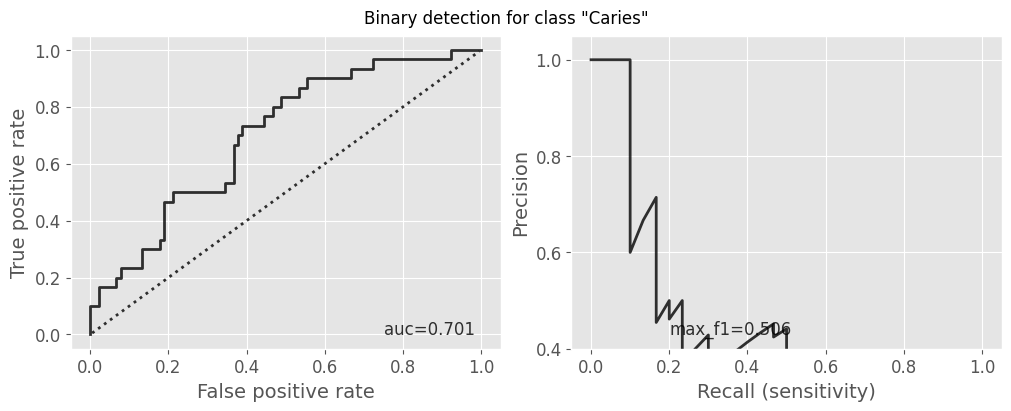


Performance for class 3: "Deep Caries"
{'precision': 0.4054, 'recall': 0.5, 'threshold': 0.13899999856948853, 'f1': 0.4478}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


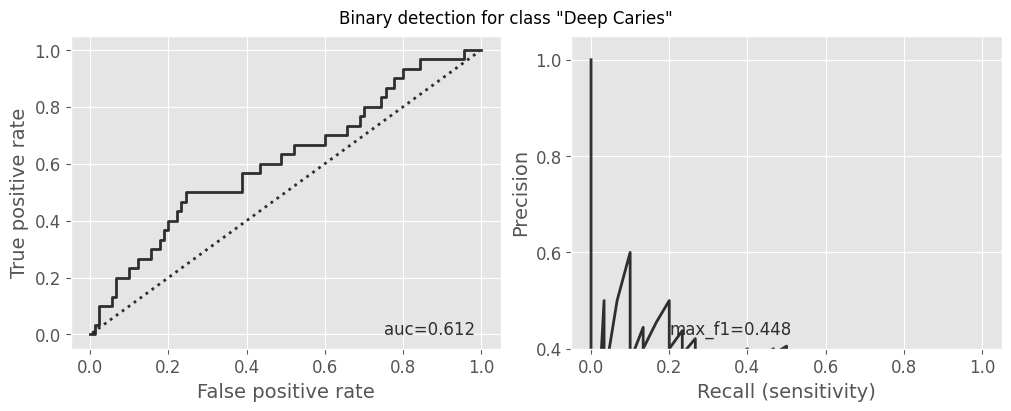


Performance for class 0: "Impacted"
{'precision': 0.6667, 'recall': 0.9333, 'threshold': 0.0714000016450882, 'f1': 0.7778}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


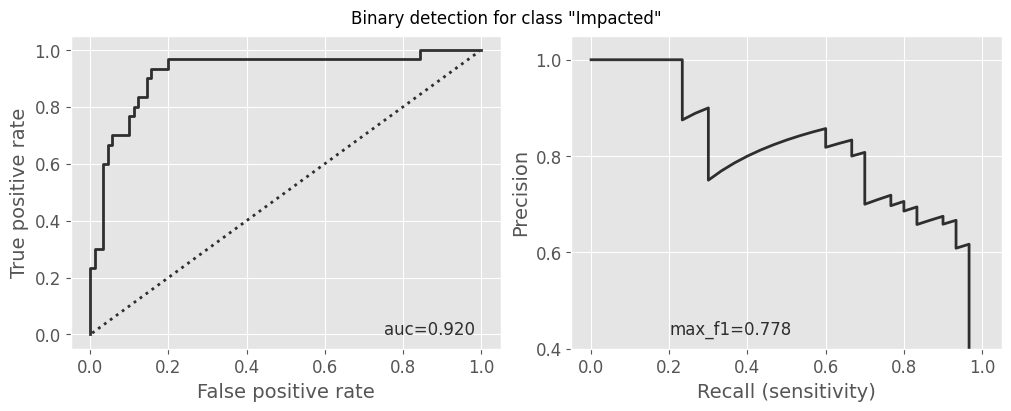


Performance for class 2: "Periapical Lesion"
{'precision': 0.3544, 'recall': 0.9333, 'threshold': 0.025699999183416367, 'f1': 0.5137}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


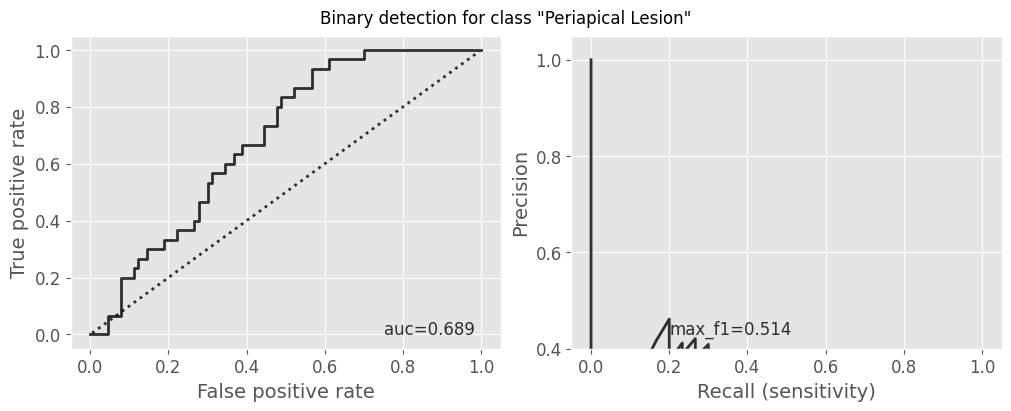

In [74]:
def max_f1_threshold(precision, recall, thr):
    """ Determine the threshold for the maximum f1 score """
    pdf = pd.DataFrame({'precision': np.round(precision, 4),
                        'recall': np.round(recall, 4),
                        'threshold': np.round(thr, 4)})
    pdf = pdf.assign(f1=np.round(2 * (pdf['precision'] * pdf['recall']) / (pdf['precision'] + pdf['recall']), 4))
    max_f1_dict = dict(pdf.loc[pdf['f1'] == pdf['f1'].max()].iloc[0])
    return max_f1_dict

def performance_plots(y_true, y_score, cl_name, figsize=(10,5)):
    # Metrics for ROC and P-R curves
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    fpr, tpr, r_thresholds = roc_curve(y_true=y_true, y_score=y_score)
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, constrained_layout=True)
    # ROC curve
    ax[0].plot(fpr, tpr, color='k', linewidth=2.0, alpha=0.8)
    ax[0].text(x=0.75, y=0, s=f'auc={auc:.3f}', alpha=0.8)
    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0, 1.2, 0.2),
              xlabel='False positive rate', ylabel='True positive rate')
    ax[0].plot([0.05, 0.95], [0.05, 0.95], transform=ax[0].transAxes, color='k',
               linewidth=2, alpha=0.8, linestyle=':')

    # PR curve
    ax[1].plot(recall, precision, color='k', linewidth=2.0, alpha=0.8)
    ax[1].text(x=0.2, y=0.43, s=f'max_f1={max_f1_dict.get("f1"):.3f}', alpha=0.8)
    ax[1].set(xlim=[-0.05, 1.05], ylim=[0.4, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.4, 1.2, 0.2),
              xlabel='Recall (sensitivity)', ylabel='Precision')

    fig.suptitle(f'Binary detection for class "{cl_name}"', fontsize=12)

    return fig, ax

figsize = (10, 4)
for cl, cl_name in list(label_dict.items()):
    y_true = [1 if c == cl else 0 for c in pred_df['cl'].values]
    y_score=pred_df[cl]
    print(f'Performance for class {cl}: "{cl_name}"')
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)
    print(max_f1_dict)
    fig, ax = performance_plots(y_true=y_true, y_score=y_score, cl_name=cl_name, figsize=figsize)
    plt.show()
    print()

Visualization: Grad-CAM
While deep learning has facilitated unprecedented accuracy in image classification, object detection, and image segmentation, one of their biggest problems is model interpretability, a core component in model understanding and model debugging.

In practice, deep learning models are treated as “black box” methods, and many times we have no reasonable idea as to:

Where the network is “looking” in the input image
Which series of neurons activated in the forward-pass during inference/prediction
How the network arrived at its final output
That raises an interesting question — how can you trust the decisions of a model if you cannot properly validate how it arrived there?

To help deep learning practitioners visually debug their models and properly understand where it’s “looking” in an image, Selvaraju et al. created Gradient-weighted Class Activation Mapping, or more simply, Grad-CAM:

"Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.”

Using Grad-CAM, we can visually validate where our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns.

In [75]:
#@title Import libraries
"""
Advanced model class for training and inference
With automated learning rate scheduling and TensorBoard logging
Andreas Werdich
Center for Computational Biomedicine
Harvard Medical School
"""

import logging
from typing import Any
# Pytorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, ResNet50_Weights
# Lightning module
from lightning.pytorch import LightningModule
from lightning.pytorch.utilities.types import OptimizerLRScheduler, STEP_OUTPUT
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from lightning.pytorch.callbacks import LearningRateFinder
# Torchmetrics
import torchmetrics.classification as tmc

logger = logging.getLogger(name=__name__)
torch.set_float32_matmul_precision(precision='high')


def performance_metrics(metric_dict, logits, target, metric_prefix='train'):
    """
    Calculate performance metrics for given logits and targets.

    Args:
        metric_dict (dict): Dictionary containing the metric name as key and the metric function as value.
        logits (torch.Tensor): The predicted logits from the model.
        target (torch.Tensor): The ground truth targets.
        metric_prefix (str, optional): Prefix to be added to the metric name. Defaults to 'train'.

    Returns:
        dict: Dictionary containing the performance metrics with metric name prefixed by metric_prefix.
    """
    preds = nn.Softmax(dim=1)(logits)
    performance_dict = {}
    for metric_name, metric in metric_dict.items():
        performance_dict.update({f'{metric_prefix}_{metric_name}': metric(preds=preds, target=target)})
    return performance_dict


def average_performance_metrics(step_metrics_list, decimals=3):
    """
    This method calculates the average performance metrics.
    Parameters:
    - step_metrics_list (list): A list of dictionaries where each dictionary represents the metrics for a step.
    - decimals (int, optional): The number of decimal places to round the average metrics to. Defaults to 3.
    Returns:
    - average_metrics (dict): A dictionary containing the average value for each performance metric.
    """
    average_metrics = {}
    for metric in step_metrics_list[0].keys():
        metric_value = torch.stack([x.get(metric) for x in step_metrics_list])
        # Remove any zero values before averaging
        metric_value = metric_value[metric_value.nonzero().squeeze()]
        metric_value = metric_value.mean().detach().cpu().numpy().round(decimals)
        average_metrics[metric] = metric_value
    return average_metrics


class FineTuneLearningRateFinder(LearningRateFinder):
    """
    FineTuneLearningRateFinder is a class that extends the LearningRateFinder class.
    It is used to find the optimal learning rate for fine-tuning a model during training.
    Attributes:
        milestones (List[int]): A list of epoch numbers at which the learning rate should be evaluated.
    """
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)


class ResNet50Model:
    """
    This class represents a ResNet-50 model for image classification.
    Attributes:
    - n_outputs (int): The number of output classes for the model.
    Methods:
    - __init__(self, n_outputs=4): Initializes a new instance of the ResNet50Model class.
    - create_model(self): Creates the ResNet-50 model with a custom fully connected layer.
    """

    def __init__(self, n_outputs=4):
        self.n_outputs = n_outputs

    def create_model(self):
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(in_features=model.fc.in_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.n_outputs)
        )
        return model


class ToothModel(LightningModule):
    """
    This class represents a model for tooth classification using PyTorch Lightning.

    Parameters:
        - train_dataset: The dataset used for training.
        - val_dataset: The dataset used for validation.
        - test_dataset: The dataset used for testing.
        - batch_size: The batch size used for training, validation, and testing.
        - num_classes: The number of classes in the classification problem.
        - num_workers: The number of subprocesses used for data loading. Default is 1.
        - lr: The learning rate for the optimizer. Default is 1.0e-3.
        - model: Optional pretrained model. If not provided, a ResNet50 model will be used.

    Example usage:

    train_dataset = ToothDataset(train_data)
    val_dataset = ToothDataset(val_data)
    test_dataset = ToothDataset(test_data)

    tooth_model = ToothModel(train_dataset, val_dataset, test_dataset, batch_size=64, num_classes=10)

    trainer = pl.Trainer()
    trainer.fit(tooth_model)
    trainer.test(tooth_model)

    Note: replace `TRAIN_DATALOADERS`, `EVAL_DATALOADERS`, `STEP_OUTPUT`, `OptimizerLRScheduler` with the appropriate
    types.
    """

    def __init__(self,
                 train_dataset,
                 val_dataset,
                 test_dataset,
                 batch_size,
                 num_classes,
                 num_workers=1,
                 lr=1.0e-3,
                 model=None):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers
        self.lr = lr
        self.decimals = 5
        # Model architecture
        if model is None:
            self.model = ResNet50Model().create_model()
        else:
            self.model = model
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        # Performance metrics
        self.metrics = nn.ModuleDict({
            'accuracy': tmc.MulticlassAccuracy(num_classes=num_classes, average='micro'),
            'precision': tmc.MulticlassPrecision(num_classes=num_classes, average='macro'),
            'recall': tmc.MulticlassRecall(num_classes=num_classes, average='macro'),
            'f1': tmc.MulticlassF1Score(num_classes=num_classes, average='macro'),
            'auroc': tmc.MulticlassAUROC(num_classes=num_classes, average='macro')
        })
        self.train_step_metrics_list = []
        self.val_step_metrics_list = []
        self.test_step_metrics_list = []

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        dl = DataLoader(self.train_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=True,
                        pin_memory=True)
        return dl

    def val_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.val_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def test_dataloader(self) -> EVAL_DATALOADERS:
        dl = DataLoader(self.test_dataset,
                        batch_size=self.batch_size,
                        num_workers=self.num_workers,
                        shuffle=False,
                        pin_memory=True)
        return dl

    def forward(self, x, *args: Any, **kwargs: Any) -> Any:
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        train_step_metrics = {'train_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='train')
        train_step_metrics.update(performance_dict)
        self.train_step_metrics_list.append(train_step_metrics)
        return loss

    def validation_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image, target = batch
        pred = self.forward(image)
        loss = self.criterion(pred, target)
        val_step_metrics = {'val_loss': loss}
        performance_dict = performance_metrics(metric_dict=self.metrics,
                                               logits=pred,
                                               target=target,
                                               metric_prefix='val')
        val_step_metrics.update(performance_dict)
        self.val_step_metrics_list.append(val_step_metrics)
        return loss

    def predict_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> Any:
        image, label = batch
        output = self.forward(image)
        return output

    def configure_optimizers(self) -> OptimizerLRScheduler:
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        lr_scheduler_config = {'scheduler': scheduler,
                               'interval': 'epoch',
                               'frequency': 1,
                               'monitor': 'val_loss',
                               'strict': False,
                               'name': 'lr'}
        output = {'optimizer': opt, 'lr_scheduler': lr_scheduler_config}
        return output

    def on_train_epoch_end(self) -> None:
        if len(self.train_step_metrics_list) > 0:
            epoch_train_metrics = average_performance_metrics(step_metrics_list=self.train_step_metrics_list,
                                                              decimals=self.decimals)
            self.log_dict(epoch_train_metrics, prog_bar=False)
        self.train_step_metrics_list.clear()

    def on_validation_epoch_end(self) -> None:
        if len(self.val_step_metrics_list) > 0:
            epoch_val_metrics = average_performance_metrics(step_metrics_list=self.val_step_metrics_list,
                                                            decimals=self.decimals)
            # Manually log learning rate
            epoch_val_metrics['val_lr'] = self.lr
            self.log_dict(epoch_val_metrics, prog_bar=True)
        self.val_step_metrics_list.clear()

In [76]:
!pip -q install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [77]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import accuracy_score

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as pl

# We will use a library created by Jacob Gildenblat
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of plots
plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [78]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

# Lets run inference on the CPU
device = torch.device("cpu")
torch.set_float32_matmul_precision(precision='high')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA L4
CUDNN version:         90100

Device for model training/inference: cuda:0


In [79]:
# Path settings
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = 'DATA_ROOT'

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
image_output_dir = os.path.join(output_dir, 'gradcam')
Path(image_output_dir).mkdir(parents=True, exist_ok=True)

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [80]:
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,DATA_ROOT/dentex/dentex_classification/quadran...,3,5,Caries,1,27169,"[1620.388349514563, 693.2038834951456, 150.485...",train_418_3037_3_5,9,DATA_ROOT/dentex/dentex_classification/quadran...,151,358,train


In [81]:
# Create the class dictionary from the data frame
label_col = 'cl'
label_list = sorted(list(data_df['label'].unique()))
label_cl = [data_df.loc[data_df['label'] == label, label_col].values[0] for label in label_list]
label_dict = dict(zip(label_cl, label_list))
display(label_dict)

test_df = data_df.loc[data_df['dataset'] == 'test']

test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df['label'].value_counts())
print()
display(test_df.head())

{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

Found 120 samples in the test set.



,count
label,
Deep Caries,30
Impacted,30
Periapical Lesion,30
Caries,30


,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
40,611,train_508.png,508,DATA_ROOT/dentex/dentex_classification/quadran...,4,5,Deep Caries,3,36602,"[1054.0, 795.0, 115.0, 385.0]",train_508_3077_4_5,3,DATA_ROOT/dentex/dentex_classification/quadran...,115,385,test
71,41,train_536.png,536,DATA_ROOT/dentex/dentex_classification/quadran...,1,8,Impacted,0,29047,"[692.0, 449.0, 194.0, 239.57142857142844]",train_536_233_1_8,9,DATA_ROOT/dentex/dentex_classification/quadran...,194,240,test
138,458,train_461.png,461,DATA_ROOT/dentex/dentex_classification/quadran...,4,7,Deep Caries,3,35680,"[779.6666666666667, 682.1111111111112, 196.333...",train_461_2382_4_7,7,DATA_ROOT/dentex/dentex_classification/quadran...,196,297,test
249,228,train_213.png,213,DATA_ROOT/dentex/dentex_classification/quadran...,4,5,Periapical Lesion,2,24409,"[1062.264150943396, 716.0377358490566, 122.641...",train_213_1185_4_5,3,DATA_ROOT/dentex/dentex_classification/quadran...,123,250,test
274,349,train_27.png,27,DATA_ROOT/dentex/dentex_classification/quadran...,2,8,Impacted,0,21985,"[2012.0, 258.0, 149.0, 186.0]",train_27_1853_2_8,10,DATA_ROOT/dentex/dentex_classification/quadran...,149,186,test


In [82]:
# Create a pytorch data set from the data frame
# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224
batch_size = 32
num_classes = 4

# We need the same normalization as we used for training
val_transform = alb.Compose([alb.Resize(im_size, im_size),
                             alb.Normalize(mean=ImageData().image_net_mean,
                                           std=ImageData().image_net_std)])

# Create the PyTorch dataset
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col=label_col,
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)
# Create a data loader
dl = DataLoader(test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

In [83]:
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel_fancy_45.ckpt'

# Let's see if we have a saved checkpoint
# The previous training notebook should have the defined model name
model_name = 'FancyLR'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir,
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

last_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'last.ckpt'))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "last.ckpt" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "last.ckpt" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Using checkpoint file "last.ckpt" in DATA_ROOT/model/FancyLR/version_1/checkpoints.


In [84]:
model = ToothModel.load_from_checkpoint(checkpoint_file,
                                        test_dataset=test_dataset,
                                        map_location=device,
                                        batch_size=batch_size,
                                        num_classes=num_classes,
                                        num_workers=1)

In [85]:
# Create one batch of data
image_batch, label_batch = next(iter(dl))

max_pixel_value = 1
image_mean = torch.tensor(np.multiply(ImageData().image_net_mean, max_pixel_value))
image_std = torch.tensor(np.multiply(ImageData().image_net_std, max_pixel_value))

# Create a list of images from the input batch
torch_image_list = [image_batch[i] for i in range(batch_size)]

# Un-normalize the images and clip values [0, 1]
image_list = [torch.permute(torch_image, (1, 2, 0)) for torch_image in torch_image_list]
image_list = [(torch.mul(image, image_std) + image_mean).detach().numpy() for image in image_list]
image_list = [np.clip(image, 0, max_pixel_value) for image in image_list]
# Run the batch through the model
outputs = model(image_batch)
predicted_labels = torch.argmax(outputs, dim=1).detach().numpy()
outputs = outputs.detach().numpy()
true_labels = label_batch.numpy()

# Get the image names from the data frame
true_labels_df = test_df['cl'].values[:batch_size]
true_labels_names_df = test_df['label'].values[:batch_size]
file_names = test_df['file_name'].values[:batch_size]

# Print the output_classes
print(f'Ground truth labels for batch: {true_labels}')
print(f'Labels from data frame:        {true_labels_df}')
print(f'Model predictions for batch:   {predicted_labels}')

Ground truth labels for batch: [3 0 3 2 0 0 2 1 3 2 2 2 0 3 0 2 2 1 3 2 3 2 2 0 2 3 1 1 1 1 3 0]
Labels from data frame:        [3 0 3 2 0 0 2 1 3 2 2 2 0 3 0 2 2 1 3 2 3 2 2 0 2 3 1 1 1 1 3 0]
Model predictions for batch:   [1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1]


In [86]:
# Get the PyTorch model out of the lightning instance
torch_model = model.model

# Target layers
target_layers = [torch_model.layer4[-1]]
print(target_layers)

# Input tensor
input_tensor = image_batch

# Predicted labels
targets = [ClassifierOutputTarget(t) for t in predicted_labels]

# Instantiate the GradCAM class
with GradCAM(model=torch_model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=image_batch, targets=targets, aug_smooth=True, eigen_smooth=True)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [87]:
# Create the overlay
# RGB input image
idx = 3
img = image_list[idx]

for idx, img in enumerate(image_list):

    print(f'Image {idx +1} of {len(image_list)}')
    image_name = os.path.splitext(file_names[idx])[0]
    print(image_name)
    print()

    vis = show_cam_on_image(img=img,
                            mask=grayscale_cam[idx],
                            use_rgb=True,
                            image_weight=0.5)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(vis)
    for axi in ax:
        axi.set(xticks=[], yticks=[])

    fig.suptitle(
        (f'True: {label_dict.get(true_labels[idx])}\n'
         f'Predicted: {label_dict.get(predicted_labels[idx])}'), x=0.25, fontsize=SMALL_SIZE)

    plt.tight_layout()
    plt.subplots_adjust(top=0.999)

    # Save the image
    output_file_name = f'{image_name}_gradcam.png'
    output_file = os.path.join(image_output_dir, output_file_name)
    plt.savefig(output_file, bbox_inches='tight')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.